# ЛР 5
Виконав: Олег Басистий  

[гітхаб репо](https://github.com/n1n1n1q/SignalProcessingLabs)

In [1]:
!pip install PyRQA antropy nolds

In [2]:
import antropy as ant
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.io import loadmat
from scipy.signal import butter, coherence, freqz, lfilter


In [3]:
np.random.seed(67)

## Завдання 1

In [4]:
def load_mat_signal(file_path):
    return np.array(loadmat(file_path)['sig'][0])

In [5]:
healthy = load_mat_signal('../lab01/data/eeg/eeg_healthy_1.mat')
sick = load_mat_signal('../lab01/data/eeg/eeg_sick_1.mat')
fs = 256

### Завдання 1.1

In [ ]:
orders = [2, 3, 4, 5]
entropy_healthy = [ant.perm_entropy(healthy, order=n) for n in orders]
entropy_sick= [ant.perm_entropy(sick, order=n) for n in orders]

In [7]:
for n, h, s in zip(orders, entropy_healthy, entropy_sick):
    print(f"n={n}: Healthy={h:.4f}, Sick={s:.4f}")

n=2: Healthy=0.7909, Sick=0.9530
n=3: Healthy=1.6485, Sick=1.4851
n=4: Healthy=2.1371, Sick=1.7459
n=5: Healthy=3.0768, Sick=2.2312


### Завдання 1.2

In [8]:
def butter_filter(data, fs, band, order=5):
    nyq = fs / 2
    btype = 'band'
    Wn = [band[0] / nyq, band[1] / nyq]
    b, a = butter(order, Wn, btype=btype)
    w, h = freqz(b, a, worN=1024, fs=fs)
    filtered = lfilter(b, a, data, axis=0)
    return filtered, w, h

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    filtered, _, _ = butter_filter(data, fs, [lowcut, highcut], order)
    return filtered

In [9]:
bands = {
    "delta": (0.5, 3),
    "theta": (4, 6),
    "alpha": (8, 13),
    "beta": (14, 40),
    "gamma": (40, fs/2 - 1)
}

In [10]:
band_entropy = {band: {"healthy": [], "patient": []} for band in bands}

for band, (low, high) in bands.items():
    eeg_h_filt = bandpass_filter(healthy, low, high, fs)
    eeg_p_filt = bandpass_filter(sick, low, high, fs)
    for n in orders:
        band_entropy[band]["healthy"].append(ant.perm_entropy(eeg_h_filt, order=n))
        band_entropy[band]["patient"].append(ant.perm_entropy(eeg_p_filt, order=n))

### Завдання 1.3

In [11]:
table_data = []

for band in band_entropy.keys():
    for i, n in enumerate(orders):
        h = band_entropy[band]["healthy"][i]
        p = band_entropy[band]["patient"][i]
        table_data.append({
            'Ритм': band,
            'Порядок': n,
            'Ентропія здорової людини': f"{h:.4f}",
            'Ентропія хворої людини': f"{p:.4f}"
        })

df_entropy = pd.DataFrame(table_data)
df_entropy

,Ритм,Порядок,Ентропія здорової людини,Ентропія хворої людини
0,delta,2,0.5109,0.4011
1,delta,3,0.5420,0.4318
2,delta,4,0.5742,0.4624
3,delta,5,0.6064,0.4930
4,theta,2,0.9998,0.9998
5,theta,3,1.2854,1.2788
6,theta,4,1.5735,1.5579
7,theta,5,1.8639,1.8347
8,alpha,2,1.0000,0.9999
9,alpha,3,1.5068,1.5044


Задля порівнюваністю між різними порядками, можна нормувати ентропію.

In [12]:
import math

table_data_norm = []

for band in band_entropy.keys():
    for i, n in enumerate(orders):
        h = band_entropy[band]["healthy"][i]
        p = band_entropy[band]["patient"][i]
        
        max_entropy = math.log2(math.factorial(n))
        h_norm = h / max_entropy
        p_norm = p / max_entropy
        
        table_data_norm.append({
            'Ритм': band,
            'Порядок': n,
            'Нормована ентропія здорової людини': f"{h_norm:.4f}",
            'Нормована ентропія хворої людини': f"{p_norm:.4f}",
            'Різниця (%)': f"{(h_norm - p_norm):.2f}"
        })

df_entropy_norm = pd.DataFrame(table_data_norm)
df_entropy_norm

,Ритм,Порядок,Нормована ентропія здорової людини,Нормована ентропія хворої людини,Різниця (%)
0,delta,2,0.5109,0.4011,0.11
1,delta,3,0.2097,0.1670,0.04
2,delta,4,0.1252,0.1009,0.02
3,delta,5,0.0878,0.0714,0.02
4,theta,2,0.9998,0.9998,-0.00
5,theta,3,0.4973,0.4947,0.00
6,theta,4,0.3432,0.3398,0.00
7,theta,5,0.2699,0.2656,0.00
8,alpha,2,1.0000,0.9999,0.00
9,alpha,3,0.5829,0.5820,0.00


### Висновки; Аналіз
Ентропія перестановок показує, наскільки випадковим або структурованим є сигнал, враховуючи порядок n. 

Малий порядок - локальні закономірності, великий -- має більшу "пам'ять". Якщо значення ентропії близьке до 0 -- впорядкований сигнал, має якийсь певний паттерн, коли ж ближче до максимуму - випадковий.  

Для delta ритму, значення у здорової людини є вищими, ніж у хворої. Отже, низькочастотні ритми у хворого менш рандомні, ніж у здорового.  

Для alpha i theta ритмів, ентропія майже однакова, особливо на малих порядках. На більших - вона починає трохи різнитися, проте не сильно.  

Для beta ритму -- з'являються суттєві відмінності на вищих порядках. 

Для gamma -- відміностей майже нема.

Хворі люди мають меншу ентропію в delta і beta ритмах, що може свідчити про деградацію (нижчий рівень скланості) мозкової активності.  

Theta та alpha майже не різняттся, отже не є дуже чутливими до патологій на цьому датасеті. 

Gamma є дуже випадковими.  

Зростання порядку n підкреслює відмінності між групами, особливо для низьких і середніх частот.

Нормована ентропія перестановок дозволяє порівнювати складність сигналів різних порядків n, оскільки максимальне значення залежить від n.

Для delta ритму нормовані значення у здорових стабільно вищі, ніж у хворих. Тобто низькочастотна активність у хворих є більш передбачуваною та менш хаотичною. Це саме той ритм, де різниця між групами найбільша.

У theta ритмі ентропія майже однакова в обох групах. Вона дуже висока, і різниця на всіх порядках мінімальна. Отже, theta-сигнал зберігає складність незалежно від стану.

Для alpha ритму ситуація схожа: значення високі та близькі між собою, різниця лише близько 1%. Alpha не демонструє суттєвої чутливості до патології.

У beta ритмі на великих порядках (n=4-5) виділяються помітні відмінності: у здорових ентропія вища. Це може відображати складнішу когнітивну активність у здорової групи.

Для gamma різниця практично відсутня -- значення дуже високі в обох групах, майже на максимумі. Це свідчить, що високочастотні компоненти в обох групах максимально випадкові.

Загалом результати схожі до ненормованих, проте нормалізація дає кращу інтерпретованість

Зростання порядку n посилює видимість відмінностей, особливо в delta та beta ритмах.

## Завдання 2

In [13]:
fs = 1000
T = 10
N = T * fs
t = t = np.arange(N) / fs

In [14]:
noise = np.random.normal(0, 1, N)

In [15]:
pulse_T = 0.1
pulse_N = int(pulse_T * fs)
pulse = np.ones(pulse_N)
pulse_start = np.random.randint(0, N - pulse_N)
pulse_end = pulse_start + pulse_N

In [16]:
impulse_signal = np.zeros(N)
impulse_signal[pulse_start:pulse_end] = pulse

In [17]:
signal = noise + impulse_signal

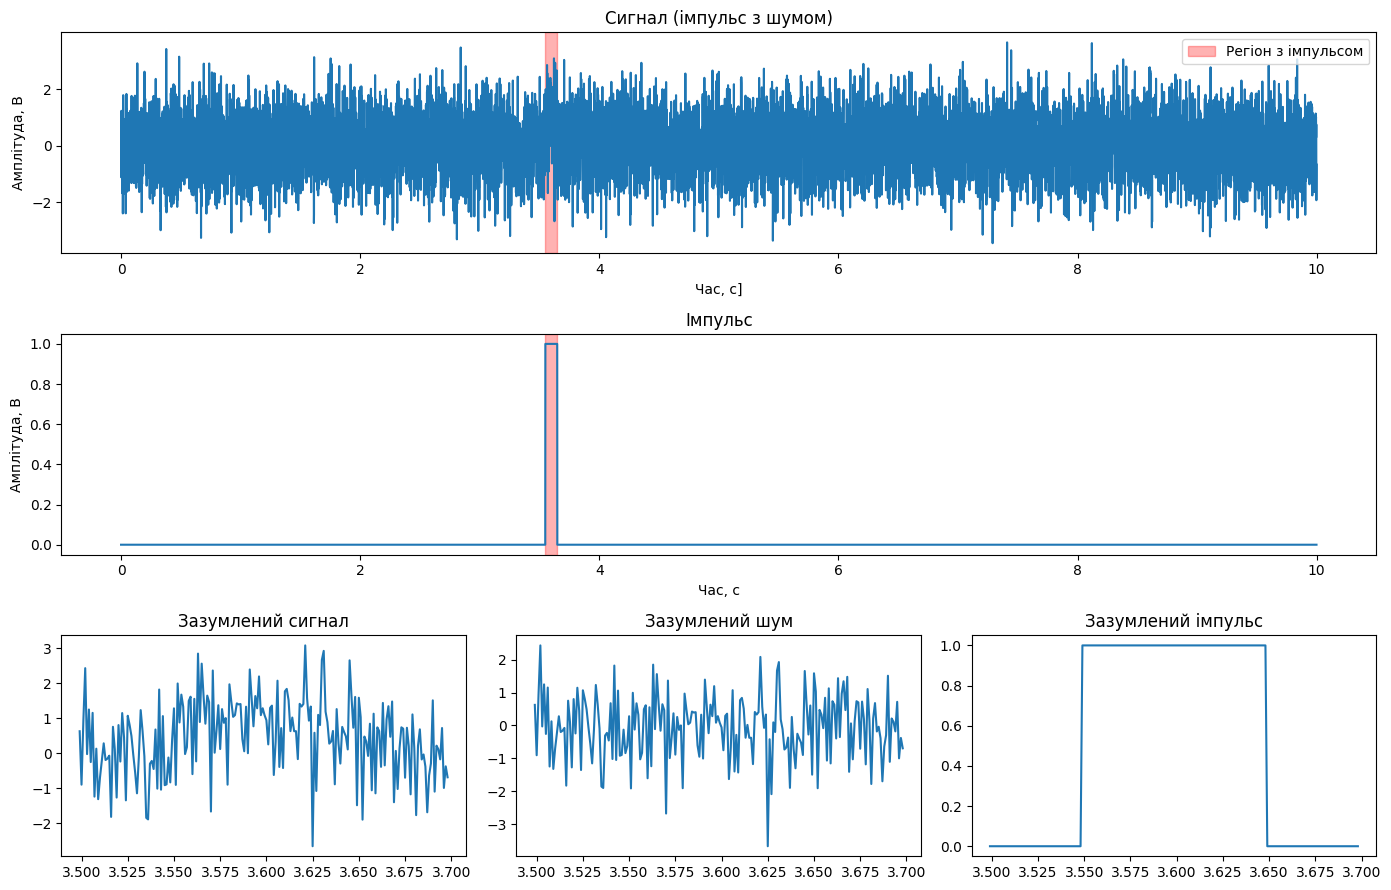

In [18]:
plt.figure(figsize=(14, 9))

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax1.plot(t, signal)
ax1.axvspan(t[pulse_start], t[pulse_end], color='r', alpha=0.3, label='Регіон з імпульсом')
ax1.set_title("Сигнал (імпульс з шумом)")
ax1.set_xlabel("Час, с]")
ax1.set_ylabel("Амплітуда, В")
ax1.legend()

ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
ax2.plot(t, impulse_signal)
ax2.axvspan(t[pulse_start], t[pulse_end], color='r', alpha=0.3)
ax2.set_title("Імпульс")
ax2.set_xlabel("Час, с")
ax2.set_ylabel("Амплітуда, В")

ax3 = plt.subplot2grid((3, 3), (2, 0))
ax3.plot(t[pulse_start - 50:pulse_end + 50], signal[pulse_start - 50:pulse_end + 50])
ax3.set_title("Зазумлений сигнал")
ax2.set_xlabel("Час, с")
ax2.set_ylabel("Амплітуда, В")

ax4 = plt.subplot2grid((3, 3), (2, 1))
ax4.plot(t[pulse_start - 50:pulse_end + 50], noise[pulse_start - 50:pulse_end + 50])
ax4.set_title("Зазумлений шум")
ax2.set_xlabel("Час, с")
ax2.set_ylabel("Амплітуда, В")

ax5 = plt.subplot2grid((3, 3), (2, 2))
ax5.plot(t[pulse_start - 50:pulse_end + 50], impulse_signal[pulse_start - 50:pulse_end + 50])
ax5.set_title("Зазумлений імпульс")
ax2.set_xlabel("Час, с")
ax2.set_ylabel("Амплітуда, В")

plt.tight_layout()
plt.show()

### Завдання 2.2

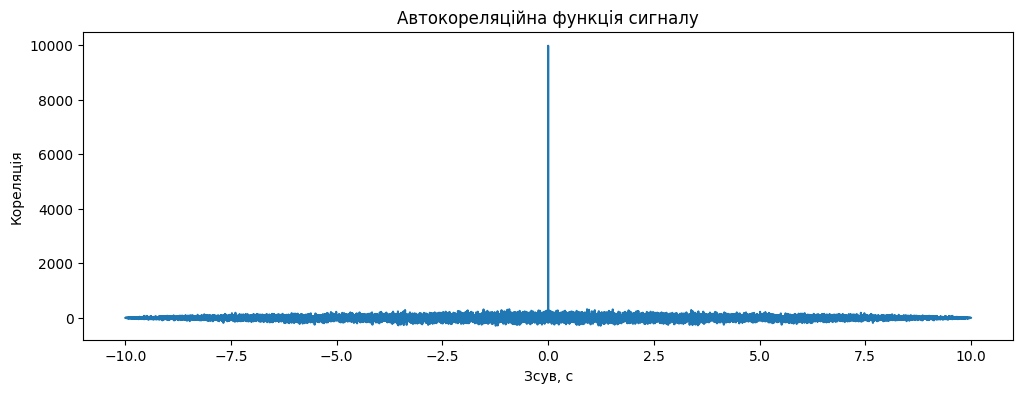

In [19]:
autocorr = np.correlate(signal, signal, mode='full')
lags = np.arange(-N + 1, N) / fs

plt.figure(figsize=(12, 4))
plt.plot(lags, autocorr)
plt.title('Автокореляційна функція сигналу')
plt.xlabel('Зсув, с')
plt.ylabel('Кореляція')
plt.show()

АКФ шуму має вершину в нулі. Максимальне значення кореляції у нульовому зсуві, бо сигнал максимально корельований сам з собою. Чим далі від 0 -- тим менше значення кореляції, оскільки випадковий шум був засемлпений з стандартного нормального розподілу (mean = 0, sigma = 1), а отже значення будуть близькі до -1 до 1 (за 3 sigmas rule 95% розподілу лежить у ціх значеннях). Чим далі від початку -- тим менша кореляція з числами з проміжку (-1; 1).

### Завдання 2.3

In [20]:
template = np.ones(pulse_N)
cross_corr = np.correlate(signal, template, mode='full')
lags_cross = np.arange(-len(template) + 1, len(signal)) / fs

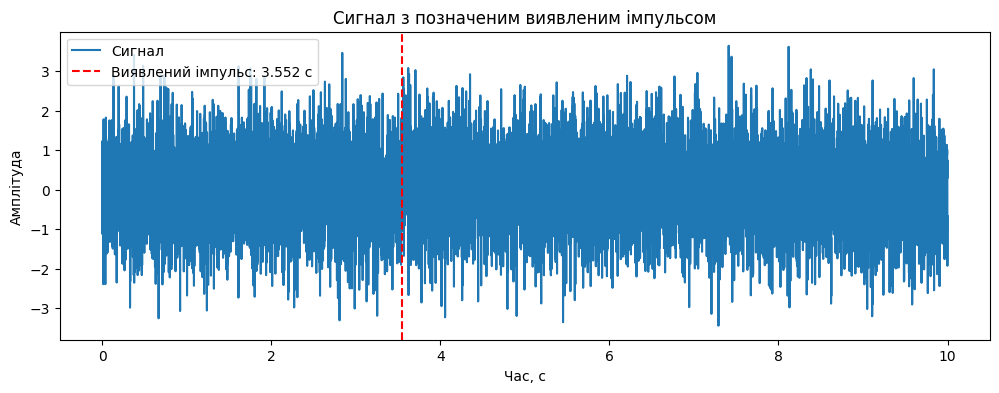

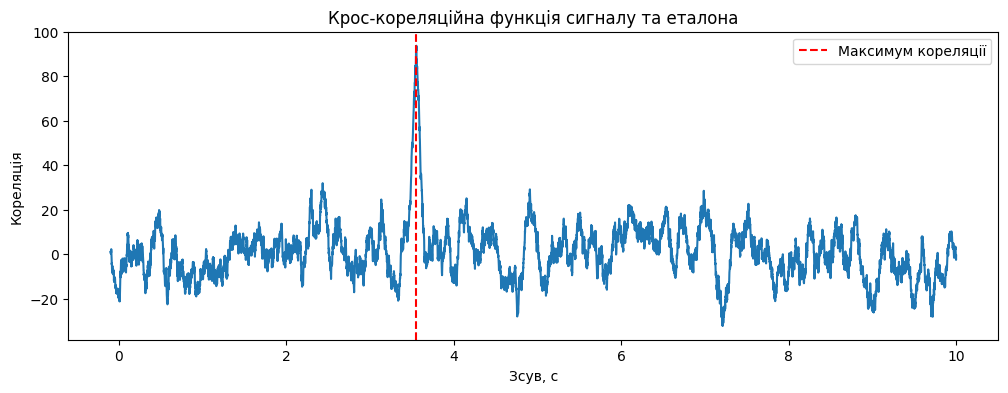

In [21]:
max_idx = np.argmax(cross_corr)
detected_time = lags_cross[max_idx]

plt.figure(figsize=(12, 4))
plt.plot(t, signal, label='Сигнал')
plt.axvline(detected_time, color='r', linestyle='--', label=f'Виявлений імпульс: {detected_time:.3f} с')
plt.title('Сигнал з позначеним виявленим імпульсом')
plt.xlabel('Час, с')
plt.ylabel('Амплітуда')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(lags_cross, cross_corr)
plt.title('Крос-кореляційна функція сигналу та еталона')
plt.xlabel('Зсув, с')
plt.ylabel('Кореляція')
plt.axvline(detected_time, color='r', linestyle='--', label='Максимум кореляції')
plt.legend()
plt.show()


In [22]:
print(f"Виявлений час появи імпульсу: {detected_time:.3f} с")

Виявлений час появи імпульсу: 3.552 с


Крос-кореляція між сигналом і прямокутним еталоном досягає максимуму там, де в сигналі знаходиться схожий прямокутний імпульс. Шум дає випадкові коливання в крос-кореляції, але імпульс дає чіткий пік.

### Завдання 2.4

In [23]:
snr_levels = [0, 5, 10]
signals_snr = {}
autocorr_snr = {}
cross_corr_snr = {}
detected_times = {}
errors = {}

true_pulse_time = t[pulse_start]

print(f"Справжнє положення імпульсу: {true_pulse_time:.3f} с")
print(f"Довжина імпульсу: {pulse_T} с")
print(f"Діапазон імпульсу: [{t[pulse_start]:.3f}, {t[pulse_end]:.3f}] с")

Справжнє положення імпульсу: 3.549 с
Довжина імпульсу: 0.1 с
Діапазон імпульсу: [3.549, 3.649] с


In [24]:
for snr in snr_levels:
    print(f"Обробка SNR = {snr} дБ")
    
    signal_power = np.mean(impulse_signal[impulse_signal != 0] ** 2)

    snr_linear = 10 ** (snr / 10)

    noise_power = signal_power / snr_linear

    noise_snr = np.random.normal(0, np.sqrt(noise_power), N)

    noisy_signal = impulse_signal + noise_snr
    signals_snr[snr] = noisy_signal

    autocorr = np.correlate(noisy_signal, noisy_signal, mode='full')
    autocorr_snr[snr] = autocorr

    cross_corr = np.correlate(noisy_signal, template, mode='full')
    cross_corr_snr[snr] = cross_corr

    max_idx = np.argmax(cross_corr)
    detected_time = lags_cross[max_idx]
    detected_times[snr] = detected_time

    error = abs(detected_time - true_pulse_time)
    errors[snr] = error
    
    print(f"Виявлений час: {detected_time:.3f} с")
    print(f"Похибка: {error:.3f} с ({error*1000:.2f} мс)")
    print(f"Максимальне значення крос-кореляції: {cross_corr[max_idx]:.2f}")
    print()

Обробка SNR = 0 дБ
Виявлений час: 3.545 с
Похибка: 0.004 с (4.00 мс)
Максимальне значення крос-кореляції: 101.14

Обробка SNR = 5 дБ
Виявлений час: 3.549 с
Похибка: 0.000 с (0.00 мс)
Максимальне значення крос-кореляції: 104.38

Обробка SNR = 10 дБ
Виявлений час: 3.549 с
Похибка: 0.000 с (0.00 мс)
Максимальне значення крос-кореляції: 97.95



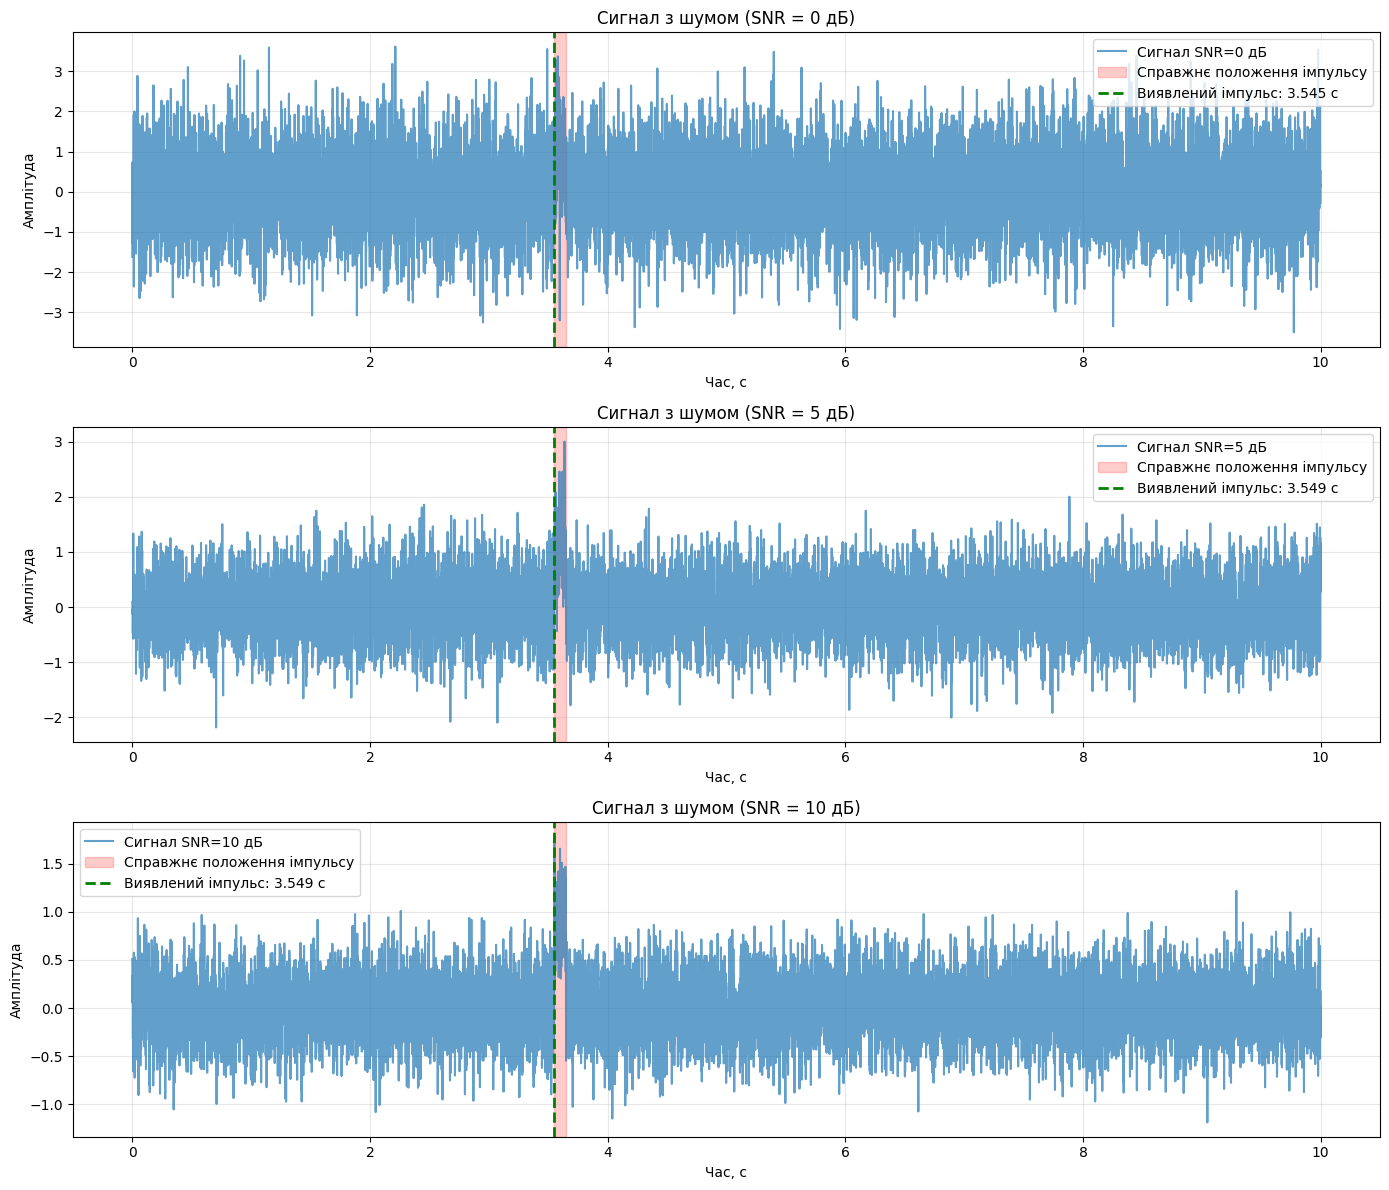

In [25]:
fig, axes = plt.subplots(len(snr_levels), 1, figsize=(14, 4*len(snr_levels)))

for i, snr in enumerate(snr_levels):
    ax = axes[i] if len(snr_levels) > 1 else axes
    
    ax.plot(t, signals_snr[snr], label=f'Сигнал SNR={snr} дБ', alpha=0.7)
    ax.axvspan(t[pulse_start], t[pulse_end], color='r', alpha=0.2, label='Справжнє положення імпульсу')
    ax.axvline(detected_times[snr], color='g', linestyle='--', linewidth=2, 
               label=f'Виявлений імпульс: {detected_times[snr]:.3f} с')
    ax.set_title(f'Сигнал з шумом (SNR = {snr} дБ)')
    ax.set_xlabel('Час, с')
    ax.set_ylabel('Амплітуда')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

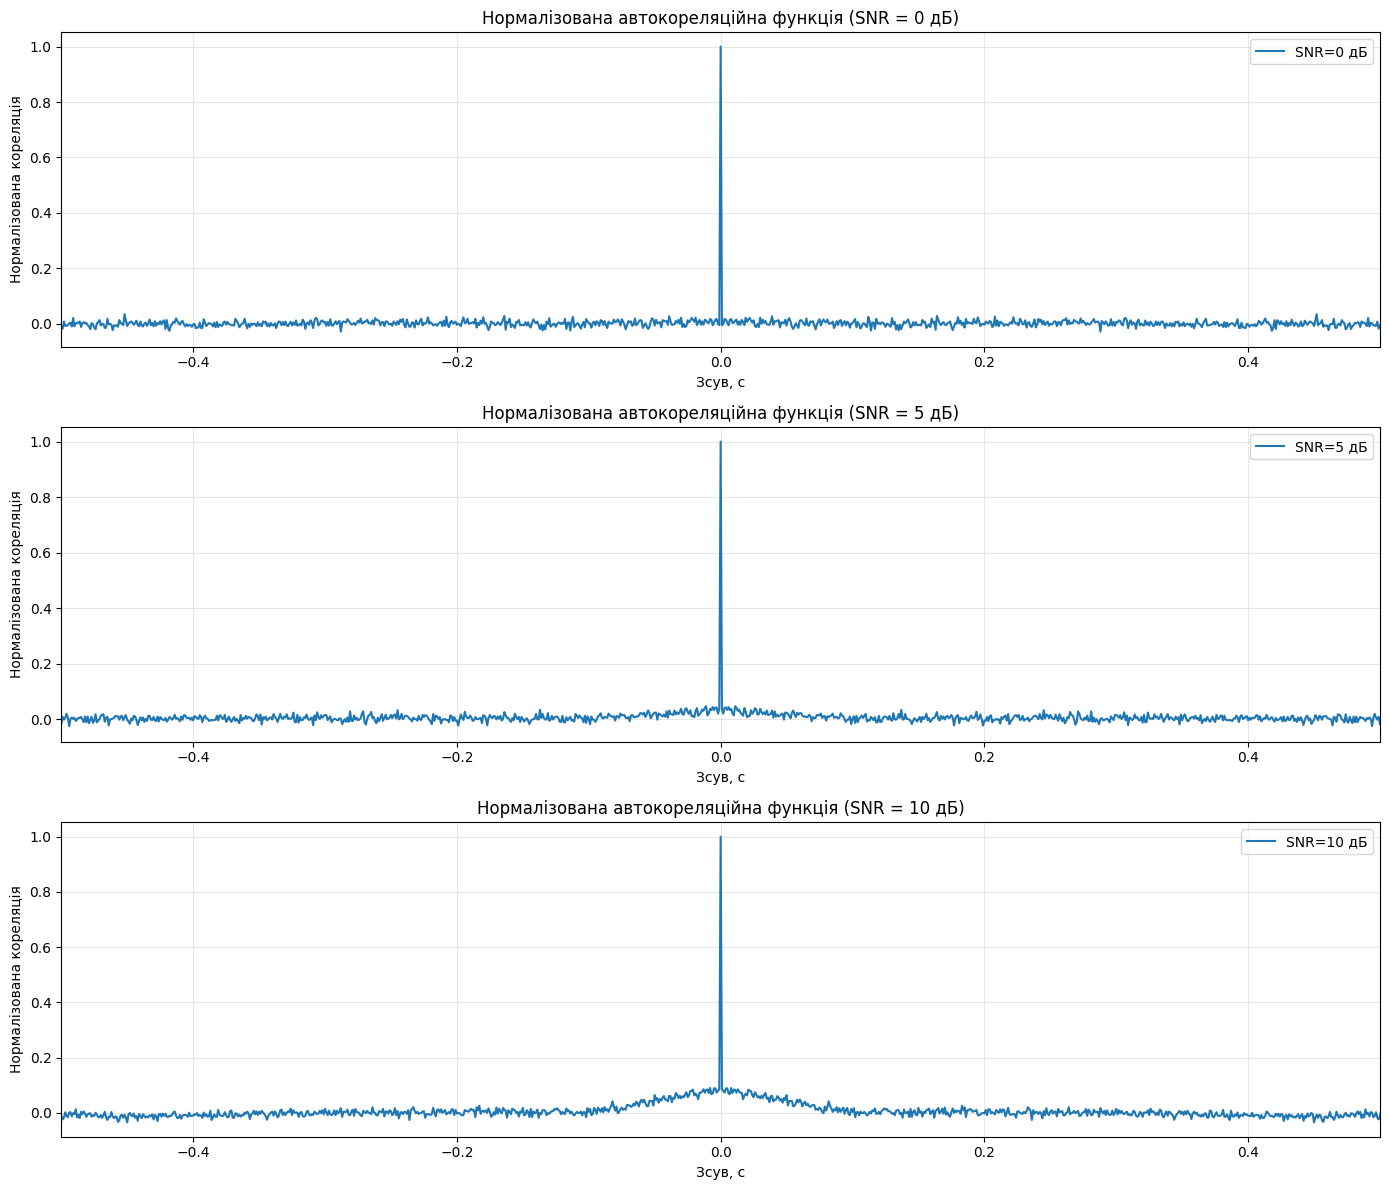

In [26]:
fig, axes = plt.subplots(len(snr_levels), 1, figsize=(14, 4*len(snr_levels)))

for i, snr in enumerate(snr_levels):
    ax = axes[i] if len(snr_levels) > 1 else axes
    
    autocorr_norm = autocorr_snr[snr] / np.max(autocorr_snr[snr])
    ax.plot(lags, autocorr_norm, label=f'SNR={snr} дБ')
    ax.set_title(f'Нормалізована автокореляційна функція (SNR = {snr} дБ)')
    ax.set_xlabel('Зсув, с')
    ax.set_ylabel('Нормалізована кореляція')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([-0.5, 0.5])

plt.tight_layout()
plt.show()

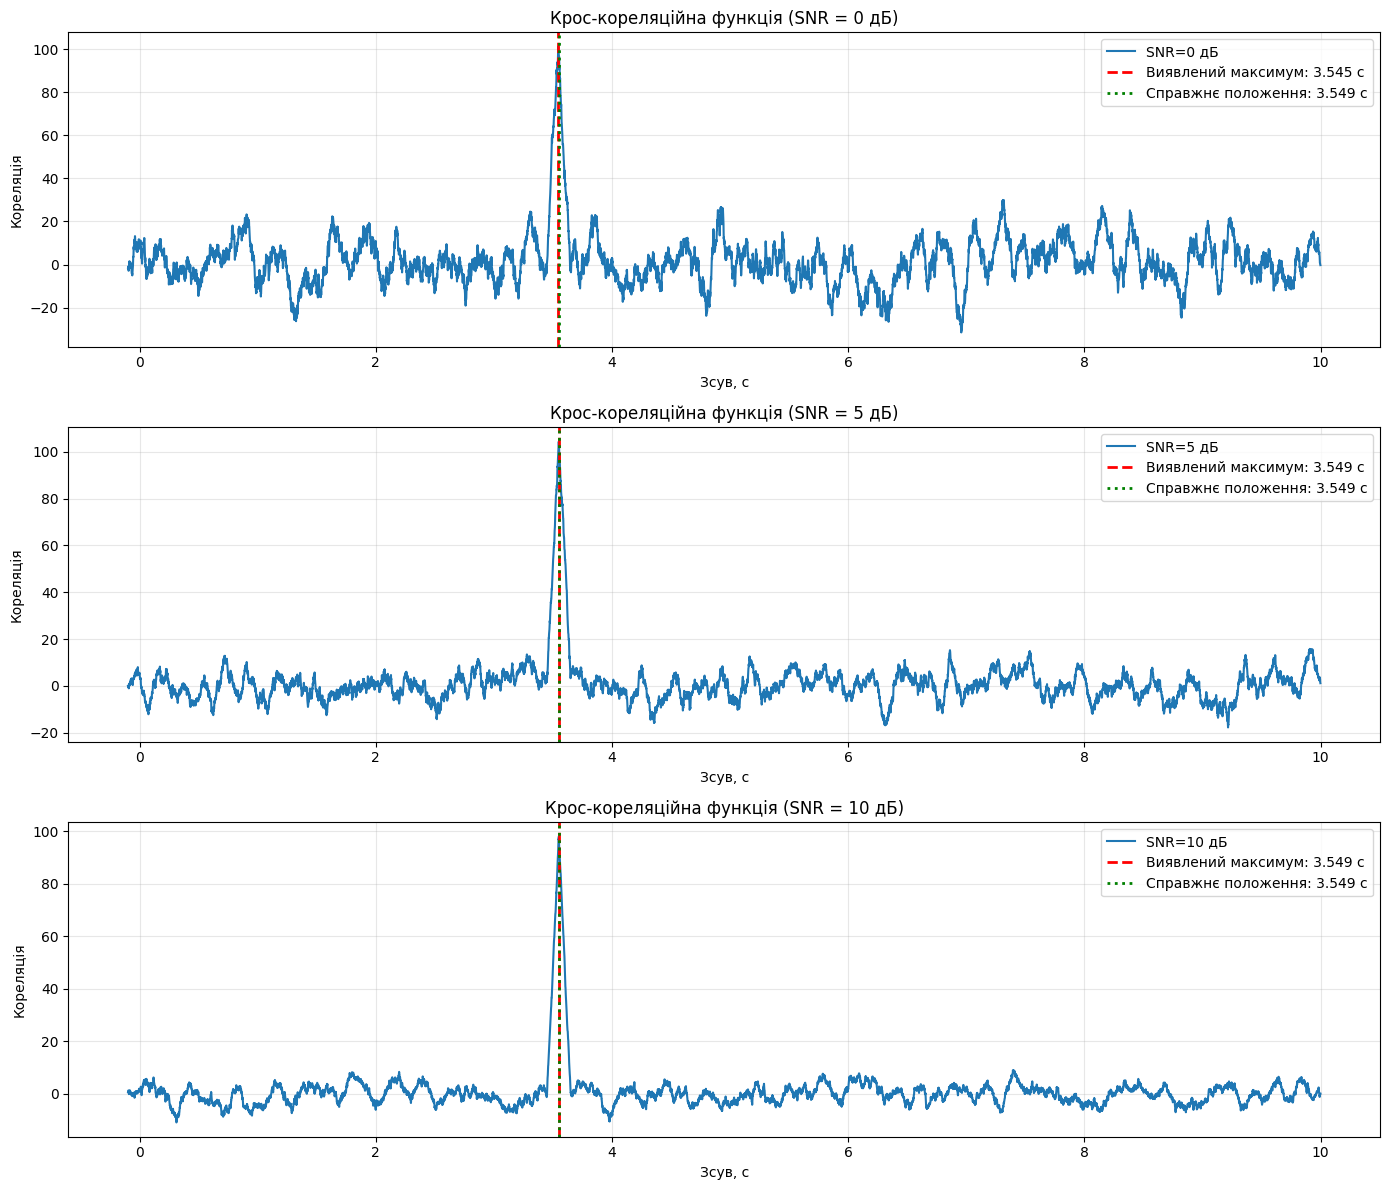

In [27]:
fig, axes = plt.subplots(len(snr_levels), 1, figsize=(14, 4*len(snr_levels)))

for i, snr in enumerate(snr_levels):
    ax = axes[i] if len(snr_levels) > 1 else axes
    
    ax.plot(lags_cross, cross_corr_snr[snr], label=f'SNR={snr} дБ')
    ax.axvline(detected_times[snr], color='r', linestyle='--', linewidth=2,
               label=f'Виявлений максимум: {detected_times[snr]:.3f} с')
    ax.axvline(true_pulse_time, color='g', linestyle=':', linewidth=2,
               label=f'Справжнє положення: {true_pulse_time:.3f} с')
    ax.set_title(f'Крос-кореляційна функція (SNR = {snr} дБ)')
    ax.set_xlabel('Зсув, с')
    ax.set_ylabel('Кореляція')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

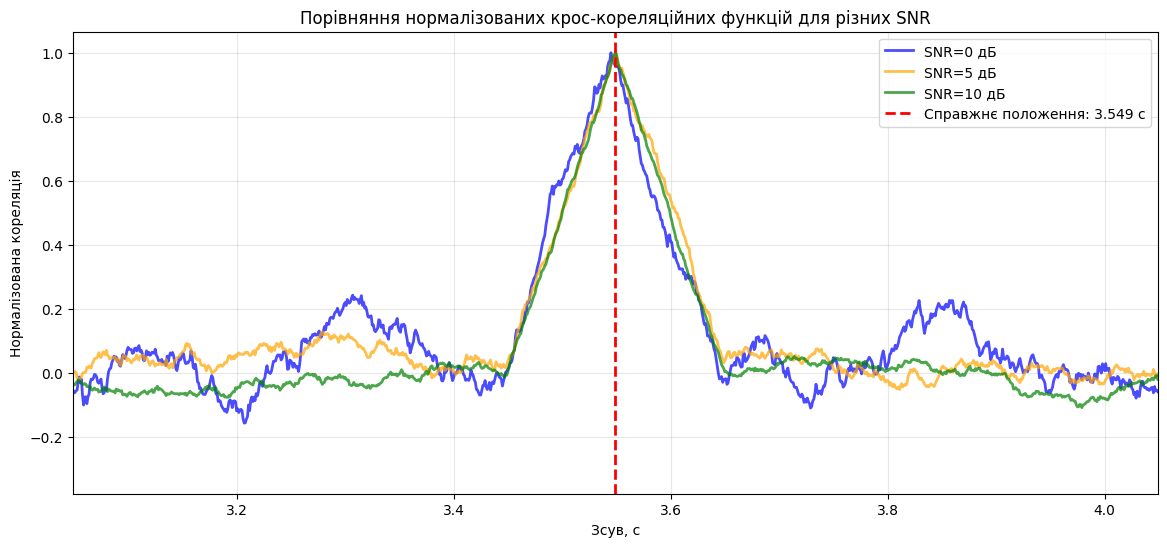

In [28]:
plt.figure(figsize=(14, 6))

colors = ['blue', 'orange', 'green']
for i, snr in enumerate(snr_levels):
    cross_corr_norm = cross_corr_snr[snr] / np.max(cross_corr_snr[snr])
    plt.plot(lags_cross, cross_corr_norm, label=f'SNR={snr} дБ', 
             alpha=0.7, linewidth=2, color=colors[i])

plt.axvline(true_pulse_time, color='red', linestyle='--', linewidth=2,
            label=f'Справжнє положення: {true_pulse_time:.3f} с')
plt.title('Порівняння нормалізованих крос-кореляційних функцій для різних SNR')
plt.xlabel('Зсув, с')
plt.ylabel('Нормалізована кореляція')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([true_pulse_time - 0.5, true_pulse_time + 0.5])
plt.show()

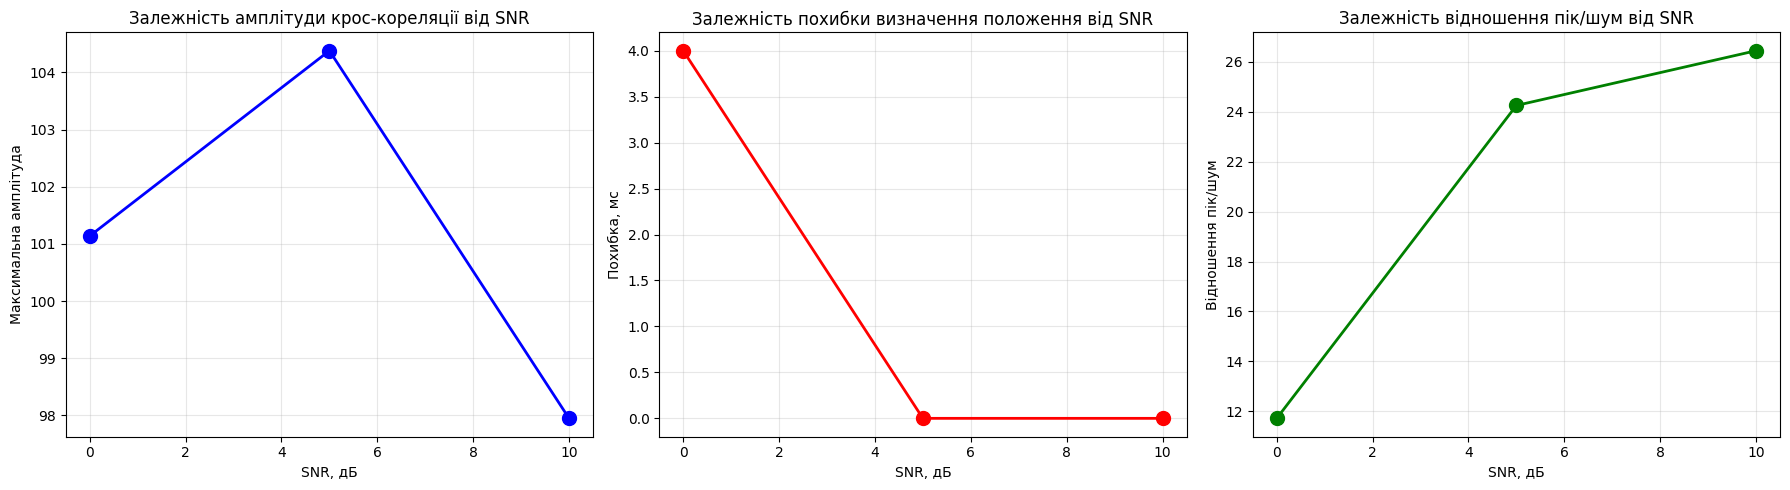

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

max_amplitudes = [np.max(cross_corr_snr[snr]) for snr in snr_levels]
axes[0].plot(snr_levels, max_amplitudes, 'o-', linewidth=2, markersize=10, color='blue')
axes[0].set_xlabel('SNR, дБ')
axes[0].set_ylabel('Максимальна амплітуда')
axes[0].set_title('Залежність амплітуди крос-кореляції від SNR')
axes[0].grid(True, alpha=0.3)

error_values = [errors[snr] * 1000 for snr in snr_levels]  # в мс
axes[1].plot(snr_levels, error_values, 'o-', linewidth=2, markersize=10, color='red')
axes[1].set_xlabel('SNR, дБ')
axes[1].set_ylabel('Похибка, мс')
axes[1].set_title('Залежність похибки визначення положення від SNR')
axes[1].grid(True, alpha=0.3)

peak_snr_values = []
for snr in snr_levels:
    max_amplitude = np.max(cross_corr_snr[snr])
    noise_level = np.std(cross_corr_snr[snr][:len(cross_corr_snr[snr])//4])
    peak_snr_values.append(max_amplitude / noise_level)

axes[2].plot(snr_levels, peak_snr_values, 'o-', linewidth=2, markersize=10, color='green')
axes[2].set_xlabel('SNR, дБ')
axes[2].set_ylabel('Відношення пік/шум')
axes[2].set_title('Залежність відношення пік/шум від SNR')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Завдання 2.5

In [30]:
print("| Значення SNR (дБ) | Амплітуда максимального піку кореляції | Знайдене положення імпульсу (мс) | Похибка визначення положення (мс) |")
print("|:-----------------:|:--------------------------------------:|:--------------------------------:|:---------------------------------:|")

for snr in snr_levels:
    max_amplitude = np.max(cross_corr_snr[snr])
    detected_position_ms = detected_times[snr] * 1000
    error_ms = errors[snr] * 1000
    
    print(f"| {snr:^17} | {max_amplitude:^38.2f} | {detected_position_ms:^32.2f} | {error_ms:^33.2f} |")

| Значення SNR (дБ) | Амплітуда максимального піку кореляції | Знайдене положення імпульсу (мс) | Похибка визначення положення (мс) |
|:-----------------:|:--------------------------------------:|:--------------------------------:|:---------------------------------:|
|         0         |                 101.14                 |             3545.00              |               4.00                |
|         5         |                 104.38                 |             3549.00              |               0.00                |
|        10         |                 97.95                  |             3549.00              |               0.00                |


* При всіх рівнях SNR автокореляційна функція має чіткий максимум у нульовому зсуві
* Зі збільшенням SNR -- пік стає гострішим, а бокові коливання зменшуються. При SNR = 0 Дб -- найбільші коливання, при 10 Дб -- найменші
* Щодо визначення положення, при найбільшому шумі (0 SNR) -- похибка найбільша, для інших значень вона близька до 0
* Амплітуда максимального піку крос-кореляції залишається приблизно однаковою 
* Зі збільшенням SNR від 0 до 10 дБ відношення пік/шум зростає від ~12 до ~26  

Метод крос-кореляції показує високу стійкість до шуму. Навіть при рівному співвідношенні сигнал/шум (SNR = 0 дБ) алгоритм досить точно знаходить імпульс. Зі зростанням SNR покращується не стільки точність виявлення (яка вже висока), скільки впевненість детекції (відношення пік/шум). Автокореляційна функція показує наявність детермінованої структури в сигналі при всіх рівнях шуму

## Завдання 3

### Завдання 3.1

In [31]:
acc_fs = 100
standing_accel = pd.read_csv("../lab01/data/imu/acc_standing.csv")
walking_accel = pd.read_csv("../lab01/data/imu/acc_walking.csv")
running_accel = pd.read_csv("../lab01/data/imu/acc_running.csv")

In [32]:
standing_accel.head()

,time,ax,ay,az,atotal
0,0.00,0.09,0.45,-0.86,0.98
1,0.01,0.32,0.36,-0.37,0.60
2,0.02,0.51,0.51,0.50,0.87
3,0.03,0.13,0.43,1.06,1.15
4,0.04,0.07,0.18,1.44,1.45


In [33]:
time_ranges = {
    "standing": (3, 60),
    "walking": (3, 27),
    "running": (3, 27)
}

lowcut = 0.3
highcut = 20
filter_order = 4

In [34]:
def prepare_accel_data(df, start_sec, end_sec, fs, lowcut, highcut, order=4):
    start_idx = int(start_sec * fs)
    end_idx = int(end_sec * fs)
    x = df['ax'].values[start_idx:end_idx]
    y = df['ay'].values[start_idx:end_idx]
    z = df['az'].values[start_idx:end_idx]
    t = np.arange(len(x)) / fs
    x_filt = bandpass_filter(x, lowcut, highcut, fs, order)
    y_filt = bandpass_filter(y, lowcut, highcut, fs, order)
    z_filt = bandpass_filter(z, lowcut, highcut, fs, order)
    
    return {
        'X': x_filt,
        'Y': y_filt,
        'Z': z_filt,
        't': t,
        'X_raw': x,
        'Y_raw': y,
        'Z_raw': z
    }

In [35]:
standing_data = prepare_accel_data(
    standing_accel, 
    time_ranges["standing"][0], 
    time_ranges["standing"][1], 
    acc_fs, 
    lowcut, 
    highcut, 
    filter_order
)

walking_data = prepare_accel_data(
    walking_accel, 
    time_ranges["walking"][0], 
    time_ranges["walking"][1], 
    acc_fs, 
    lowcut, 
    highcut, 
    filter_order
)

running_data = prepare_accel_data(
    running_accel, 
    time_ranges["running"][0], 
    time_ranges["running"][1], 
    acc_fs, 
    lowcut, 
    highcut, 
    filter_order
)

print(f"Standing: {len(standing_data['t'])} відліків, тривалість: {standing_data['t'][-1]:.2f} с")
print(f"Walking: {len(walking_data['t'])} відліків, тривалість: {walking_data['t'][-1]:.2f} с")
print(f"Running: {len(running_data['t'])} відліків, тривалість: {running_data['t'][-1]:.2f} с")

Standing: 5700 відліків, тривалість: 56.99 с
Walking: 2400 відліків, тривалість: 23.99 с
Running: 2400 відліків, тривалість: 23.99 с


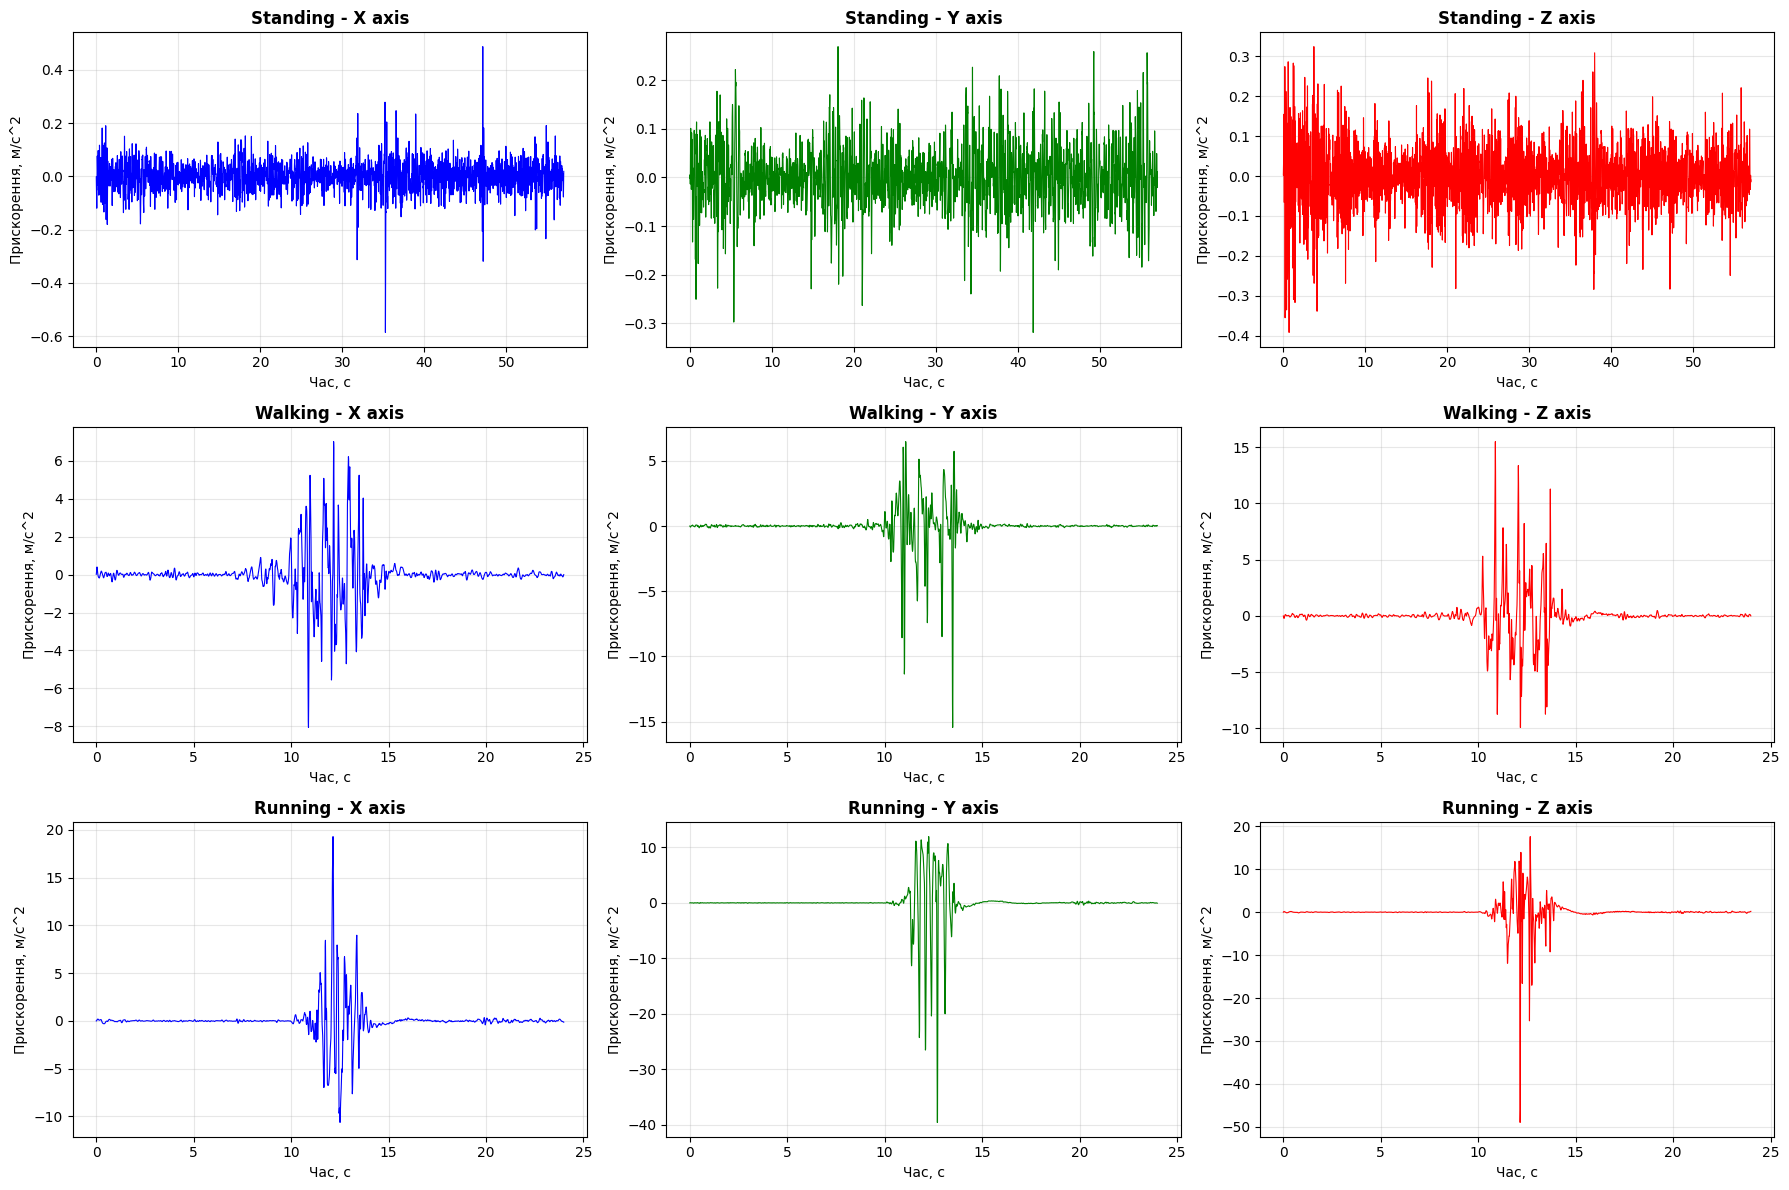

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))


axes[0, 0].plot(standing_data['t'], standing_data['X'], 'b-', linewidth=0.8)
axes[0, 0].set_title('Standing - X axis', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Час, с')
axes[0, 0].set_ylabel('Прискорення, м/c^2')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(standing_data['t'], standing_data['Y'], 'g-', linewidth=0.8)
axes[0, 1].set_title('Standing - Y axis', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Час, с')
axes[0, 1].set_ylabel('Прискорення, м/c^2')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(standing_data['t'], standing_data['Z'], 'r-', linewidth=0.8)
axes[0, 2].set_title('Standing - Z axis', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Час, с')
axes[0, 2].set_ylabel('Прискорення, м/c^2')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].plot(walking_data['t'], walking_data['X'], 'b-', linewidth=0.8)
axes[1, 0].set_title('Walking - X axis', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Час, с')
axes[1, 0].set_ylabel('Прискорення, м/c^2')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(walking_data['t'], walking_data['Y'], 'g-', linewidth=0.8)
axes[1, 1].set_title('Walking - Y axis', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Час, с')
axes[1, 1].set_ylabel('Прискорення, м/c^2')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(walking_data['t'], walking_data['Z'], 'r-', linewidth=0.8)
axes[1, 2].set_title('Walking - Z axis', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Час, с')
axes[1, 2].set_ylabel('Прискорення, м/c^2')
axes[1, 2].grid(True, alpha=0.3)

axes[2, 0].plot(running_data['t'], running_data['X'], 'b-', linewidth=0.8)
axes[2, 0].set_title('Running - X axis', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Час, с')
axes[2, 0].set_ylabel('Прискорення, м/c^2')
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].plot(running_data['t'], running_data['Y'], 'g-', linewidth=0.8)
axes[2, 1].set_title('Running - Y axis', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Час, с')
axes[2, 1].set_ylabel('Прискорення, м/c^2')
axes[2, 1].grid(True, alpha=0.3)

axes[2, 2].plot(running_data['t'], running_data['Z'], 'r-', linewidth=0.8)
axes[2, 2].set_title('Running - Z axis', fontsize=12, fontweight='bold')
axes[2, 2].set_xlabel('Час, с')
axes[2, 2].set_ylabel('Прискорення, м/c^2')
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

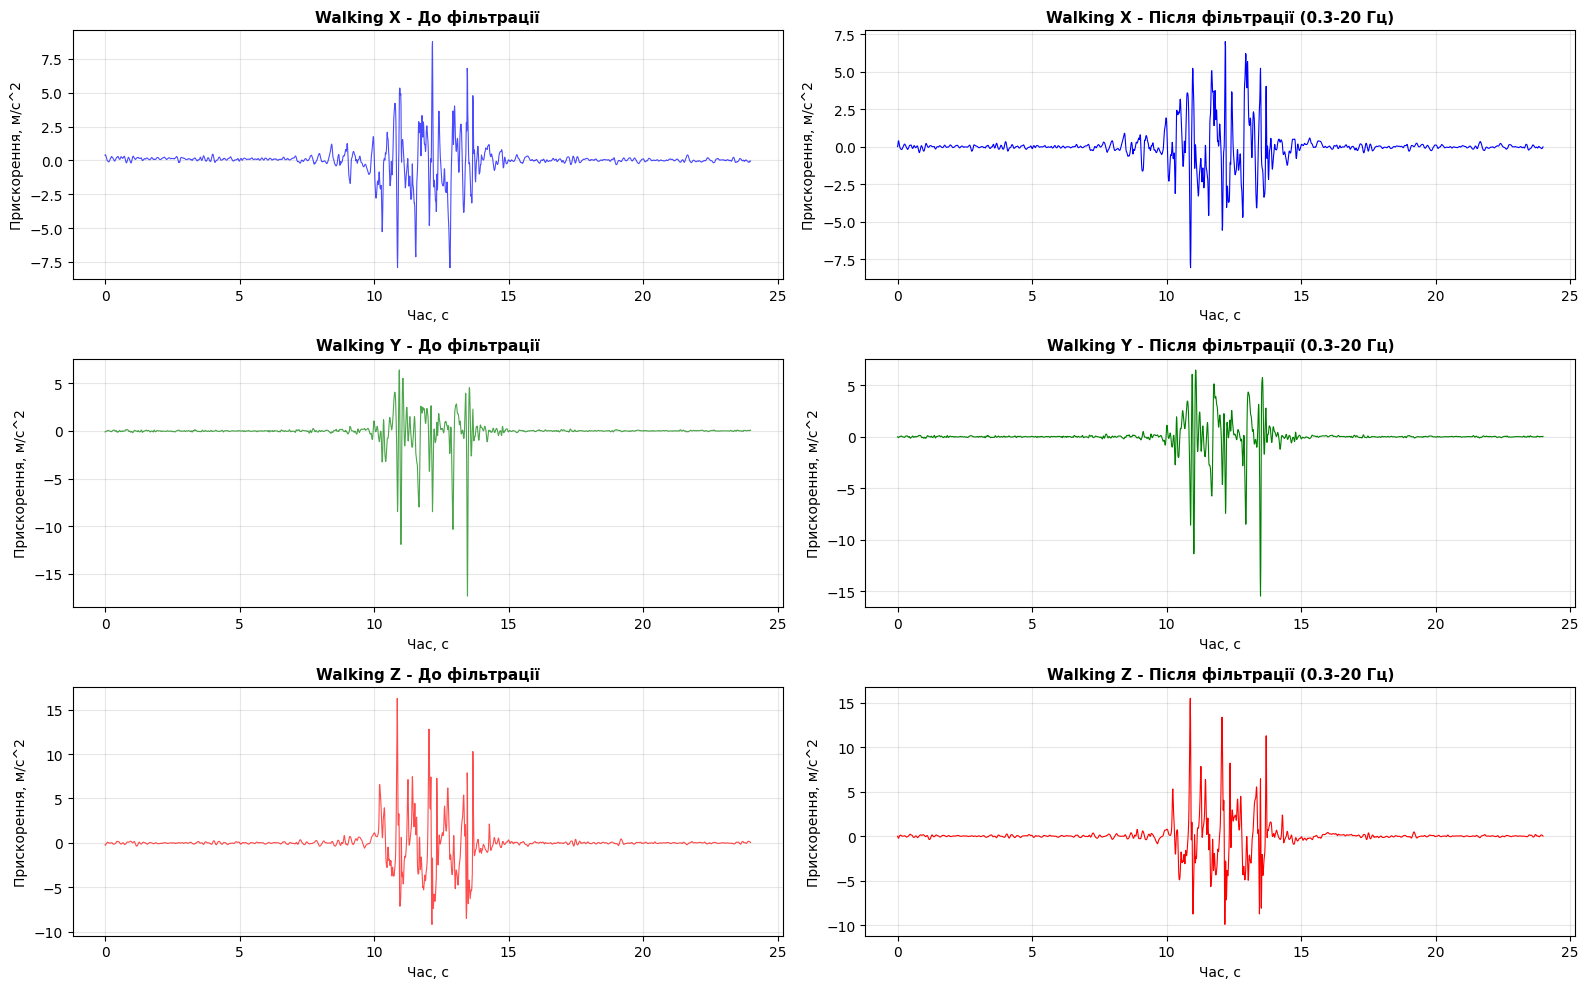

In [37]:
fig, axes = plt.subplots(3, 2, figsize=(16, 10))

axes[0, 0].plot(walking_data['t'], walking_data['X_raw'], 'b-', linewidth=0.8, alpha=0.7)
axes[0, 0].set_title('Walking X - До фільтрації', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Час, с')
axes[0, 0].set_ylabel('Прискорення, м/c^2')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(walking_data['t'], walking_data['X'], 'b-', linewidth=0.8)
axes[0, 1].set_title('Walking X - Після фільтрації (0.3-20 Гц)', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Час, с')
axes[0, 1].set_ylabel('Прискорення, м/c^2')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(walking_data['t'], walking_data['Y_raw'], 'g-', linewidth=0.8, alpha=0.7)
axes[1, 0].set_title('Walking Y - До фільтрації', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Час, с')
axes[1, 0].set_ylabel('Прискорення, м/c^2')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(walking_data['t'], walking_data['Y'], 'g-', linewidth=0.8)
axes[1, 1].set_title('Walking Y - Після фільтрації (0.3-20 Гц)', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Час, с')
axes[1, 1].set_ylabel('Прискорення, м/c^2')
axes[1, 1].grid(True, alpha=0.3)

axes[2, 0].plot(walking_data['t'], walking_data['Z_raw'], 'r-', linewidth=0.8, alpha=0.7)
axes[2, 0].set_title('Walking Z - До фільтрації', fontsize=11, fontweight='bold')
axes[2, 0].set_xlabel('Час, с')
axes[2, 0].set_ylabel('Прискорення, м/c^2')
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].plot(walking_data['t'], walking_data['Z'], 'r-', linewidth=0.8)
axes[2, 1].set_title('Walking Z - Після фільтрації (0.3-20 Гц)', fontsize=11, fontweight='bold')
axes[2, 1].set_xlabel('Час, с')
axes[2, 1].set_ylabel('Прискорення, м/c^2')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Завдання 3.2

In [38]:
segment_duration = 4
nperseg = int(segment_duration * acc_fs) 
noverlap = nperseg // 2

In [39]:
def compute_coherence_pairs(data, fs, nperseg, noverlap):
    results = {}
    pairs = [('X', 'Y'), ('X', 'Z'), ('Y', 'Z')]
    
    for pair in pairs:
        axis1, axis2 = pair

        f, Cxy = coherence(
            data[axis1], 
            data[axis2], 
            fs=fs, 
            nperseg=nperseg, 
            noverlap=noverlap
        )

        max_idx = np.argmax(Cxy)
        max_freq = f[max_idx]
        max_coh = Cxy[max_idx]
        
        results[f"{axis1}-{axis2}"] = {
            'freq': f,
            'coherence': Cxy,
            'max_freq': max_freq,
            'max_coherence': max_coh
        }
    
    return results

In [40]:
standing_coherence = compute_coherence_pairs(standing_data, acc_fs, nperseg, noverlap)
walking_coherence = compute_coherence_pairs(walking_data, acc_fs, nperseg, noverlap)
running_coherence = compute_coherence_pairs(running_data, acc_fs, nperseg, noverlap)

In [41]:
print("Standing Coherence Peaks:")
for pair, result in standing_coherence.items():
    print(f"{pair}: Max Coherence = {result['max_coherence']:.4f} at {result['max_freq']:.2f} Hz")
print("\nWalking Coherence Peaks:")
for pair, result in walking_coherence.items():
    print(f"{pair}: Max Coherence = {result['max_coherence']:.4f} at {result['max_freq']:.2f} Hz")
print("\nRunning Coherence Peaks:")
for pair, result in running_coherence.items():
    print(f"{pair}: Max Coherence = {result['max_coherence']:.4f} at {result['max_freq']:.2f} Hz")

Standing Coherence Peaks:
X-Y: Max Coherence = 0.5884 at 11.00 Hz
X-Z: Max Coherence = 0.5153 at 49.00 Hz
Y-Z: Max Coherence = 0.6447 at 5.75 Hz

Walking Coherence Peaks:
X-Y: Max Coherence = 0.9649 at 1.50 Hz
X-Z: Max Coherence = 0.9759 at 37.50 Hz
Y-Z: Max Coherence = 0.9711 at 1.75 Hz

Running Coherence Peaks:
X-Y: Max Coherence = 0.9950 at 16.50 Hz
X-Z: Max Coherence = 0.9981 at 23.00 Hz
Y-Z: Max Coherence = 0.9959 at 8.50 Hz


### Завдання 3.3

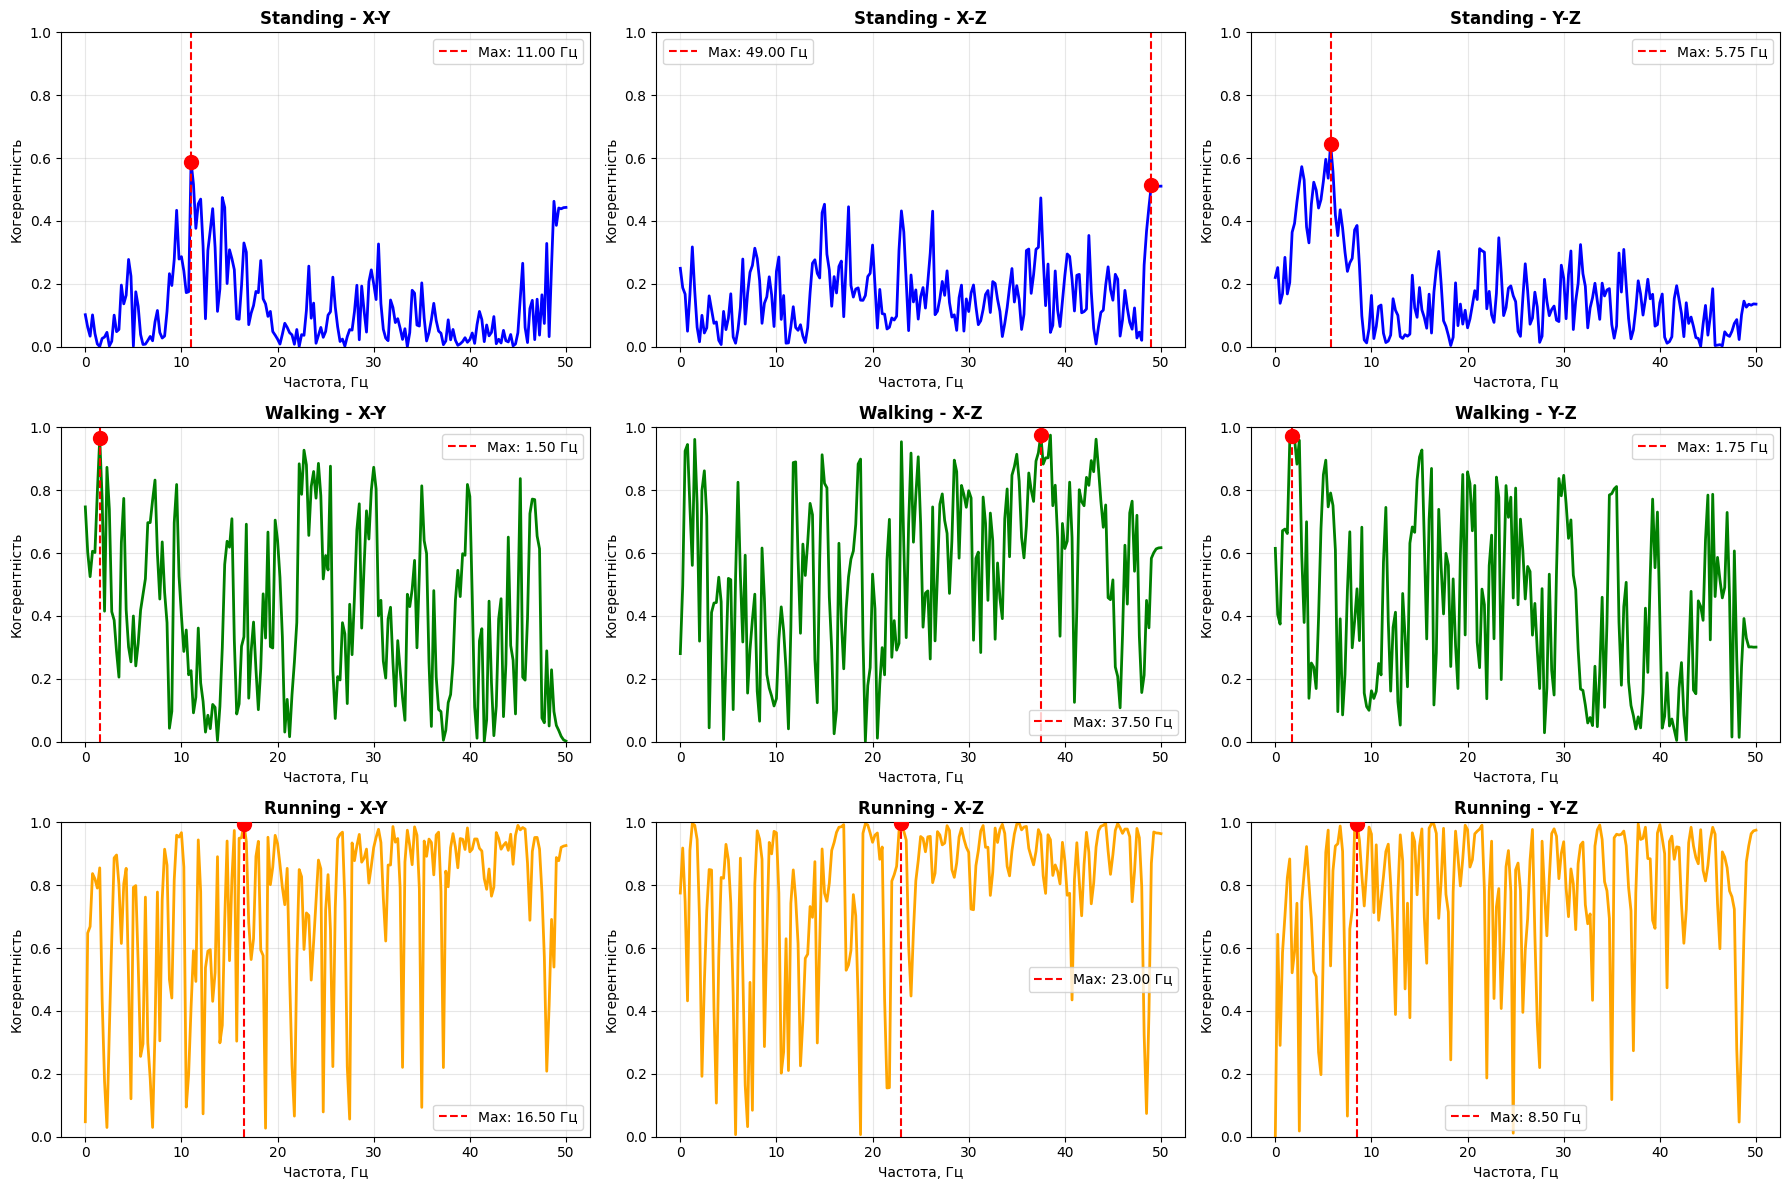

In [42]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for i, pair in enumerate(['X-Y', 'X-Z', 'Y-Z']):
    ax = axes[0, i]
    coh_data = standing_coherence[pair]
    ax.plot(coh_data['freq'], coh_data['coherence'], 'b-', linewidth=2)
    ax.axvline(coh_data['max_freq'], color='r', linestyle='--', linewidth=1.5,
               label=f"Max: {coh_data['max_freq']:.2f} Гц")
    ax.scatter([coh_data['max_freq']], [coh_data['max_coherence']], 
               color='r', s=100, zorder=5)
    ax.set_title(f'Standing - {pair}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Частота, Гц')
    ax.set_ylabel('Когерентність')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_ylim([0, 1])

for i, pair in enumerate(['X-Y', 'X-Z', 'Y-Z']):
    ax = axes[1, i]
    coh_data = walking_coherence[pair]
    ax.plot(coh_data['freq'], coh_data['coherence'], 'g-', linewidth=2)
    ax.axvline(coh_data['max_freq'], color='r', linestyle='--', linewidth=1.5,
               label=f"Max: {coh_data['max_freq']:.2f} Гц")
    ax.scatter([coh_data['max_freq']], [coh_data['max_coherence']], 
               color='r', s=100, zorder=5)
    ax.set_title(f'Walking - {pair}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Частота, Гц')
    ax.set_ylabel('Когерентність')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_ylim([0, 1])

for i, pair in enumerate(['X-Y', 'X-Z', 'Y-Z']):
    ax = axes[2, i]
    coh_data = running_coherence[pair]
    ax.plot(coh_data['freq'], coh_data['coherence'], 'orange', linewidth=2)
    ax.axvline(coh_data['max_freq'], color='r', linestyle='--', linewidth=1.5,
               label=f"Max: {coh_data['max_freq']:.2f} Гц")
    ax.scatter([coh_data['max_freq']], [coh_data['max_coherence']], 
               color='r', s=100, zorder=5)
    ax.set_title(f'Running - {pair}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Частота, Гц')
    ax.set_ylabel('Когерентність')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

### Завдання 3.4

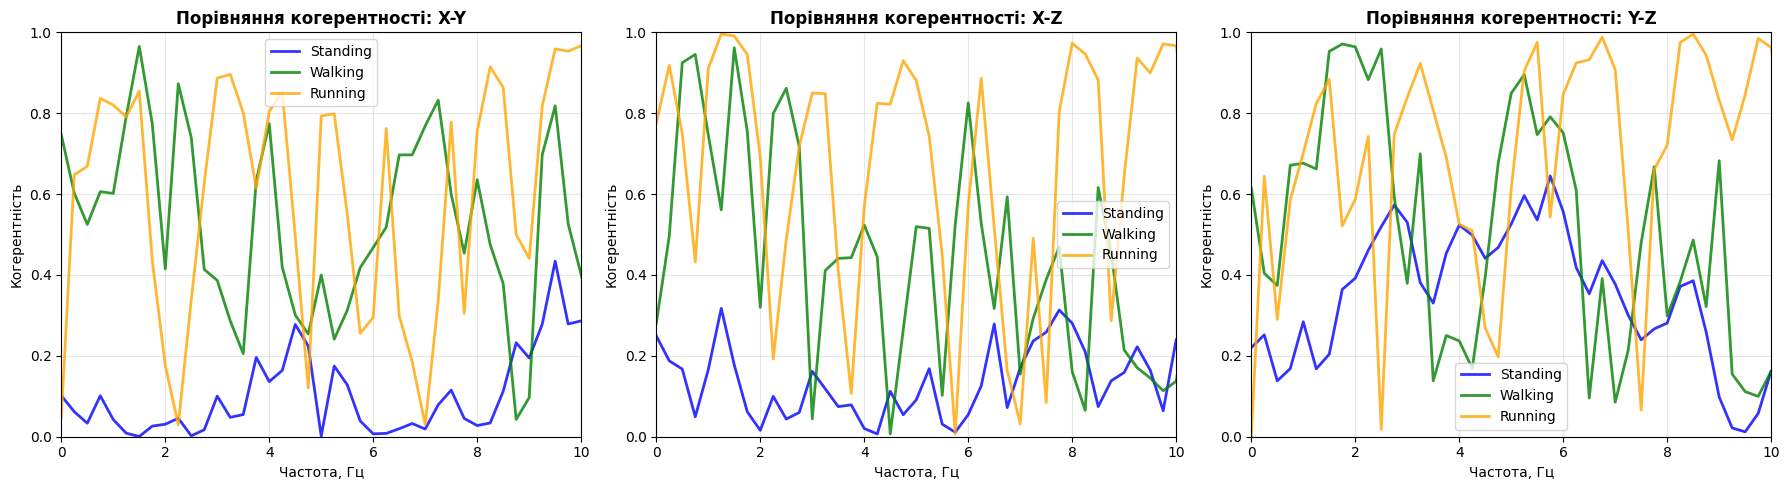

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pairs = ['X-Y', 'X-Z', 'Y-Z']
colors = {'Standing': 'blue', 'Walking': 'green', 'Running': 'orange'}

for i, pair in enumerate(pairs):
    ax = axes[i]
    
    ax.plot(standing_coherence[pair]['freq'], 
            standing_coherence[pair]['coherence'], 
            color=colors['Standing'], linewidth=2, label='Standing', alpha=0.8)

    ax.plot(walking_coherence[pair]['freq'], 
            walking_coherence[pair]['coherence'], 
            color=colors['Walking'], linewidth=2, label='Walking', alpha=0.8)
 
    ax.plot(running_coherence[pair]['freq'], 
            running_coherence[pair]['coherence'], 
            color=colors['Running'], linewidth=2, label='Running', alpha=0.8)
    
    ax.set_title(f'Порівняння когерентності: {pair}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Частота, Гц')
    ax.set_ylabel('Когерентність')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 10])

plt.tight_layout()
plt.show()

In [ ]:
table_data = []
for mode, coherence_data in zip(
    ['Standing', 'Walking', 'Running'], 
    [standing_coherence, walking_coherence, running_coherence]
):
    for pair, result in coherence_data.items():
        table_data.append({
            'Режим': mode,
            'Пара осей': pair,
            'Макс. когерентність': f"{result['max_coherence']:.4f}",
            'Частота макс. когерентності (Гц)': f"{result['max_freq']:.2f}"
        })

df_coherence = pd.DataFrame(table_data)
df_coherence

,Режим,Пара осей,Макс. когерентність,Частота макс. когерентності (Гц)
0,Standing,X-Y,0.5884,11.00
1,Standing,X-Z,0.5153,49.00
2,Standing,Y-Z,0.6447,5.75
3,Walking,X-Y,0.9649,1.50
4,Walking,X-Z,0.9759,37.50
5,Walking,Y-Z,0.9711,1.75
6,Running,X-Y,0.9950,16.50
7,Running,X-Z,0.9981,23.00
8,Running,Y-Z,0.9959,8.50


Когерентність між осями під час стояння є найнижчою серед усіх режимів. Це свідчить про слабку узгодженість коливань між осями, оскільки при стоянні рухи є випадковими.  

Когерентність ходьбе дуже сильно зростає в порівняні до стояння. Це показує сильну синхронізацію між осями. Ходьба є циклічним рухом з чіткою періодичністю, що створює узгоджені коливання в усіх трьох осях акселерометра.  

При бігові спостерігається найвища когеренція, ледь нед доходячи до 1. Біг є ще більш періодичним і динамічним рухом, ніж ходьба, що призводить до максимальної узгодженості між осями.



Щодо частот, для стоячого запису -- максимуми розкидані в дуже великому діапазоні, що підтверджує гіпотезу про маленький хаотичний рух під час запису сигналу.  

Щодо ходьби, то для пар X-Y та Y-Z максимуми когерентності спостерігаються на низьких частотах, що відповідає типовій частоті кроків при ходьбі. Пара X-Z має високий пік, що може бути пов'язаний з рухом телефону, або ж ударами п'ят об підлогу.  

Частоти бігу вищі, що відповідає півдищеному темпу рухів. 

Пари осей X-Y та Y-Z (горизонтальні компоненти) демонструють узгодженість на частотах, близьких до частоти кроків/бігу, що відображає циклічні рухи ніг.  

Пара X-Z часто має піки на вищих частотах, що може бути пов'язано з вертикальними ударами та вібраціями.  

Чим більш структурований і періодичний рух, тим вища когерентність і чіткіше виражені частотні піки.


Когерентний аналіз -- добрий інструмент для класифікації активності. За допомогою нього можна визначати не тільки стани спокою від руху, а й розрізняти типи періодичного руху на основі частоти, на якій спостерігається макс. когерентність.

## Завдання 4

### Завдання 4.1

In [45]:
signal_for_rqa = healthy
fs_rqa = 256

max_lag = len(signal_for_rqa) // 2 
autocorr_rqa = np.correlate(signal_for_rqa - np.mean(signal_for_rqa), 
                            signal_for_rqa - np.mean(signal_for_rqa), 
                            mode='full')
autocorr_rqa = autocorr_rqa[len(autocorr_rqa)//2:]

lags_rqa = np.arange(len(autocorr_rqa))

In [46]:
from scipy.signal import argrelextrema

local_minima = argrelextrema(autocorr_rqa, np.less, order=5)[0]
local_minima = local_minima[local_minima > 1]

zero_crossings = np.where(np.diff(np.sign(autocorr_rqa)))[0]
delay = zero_crossings[0]

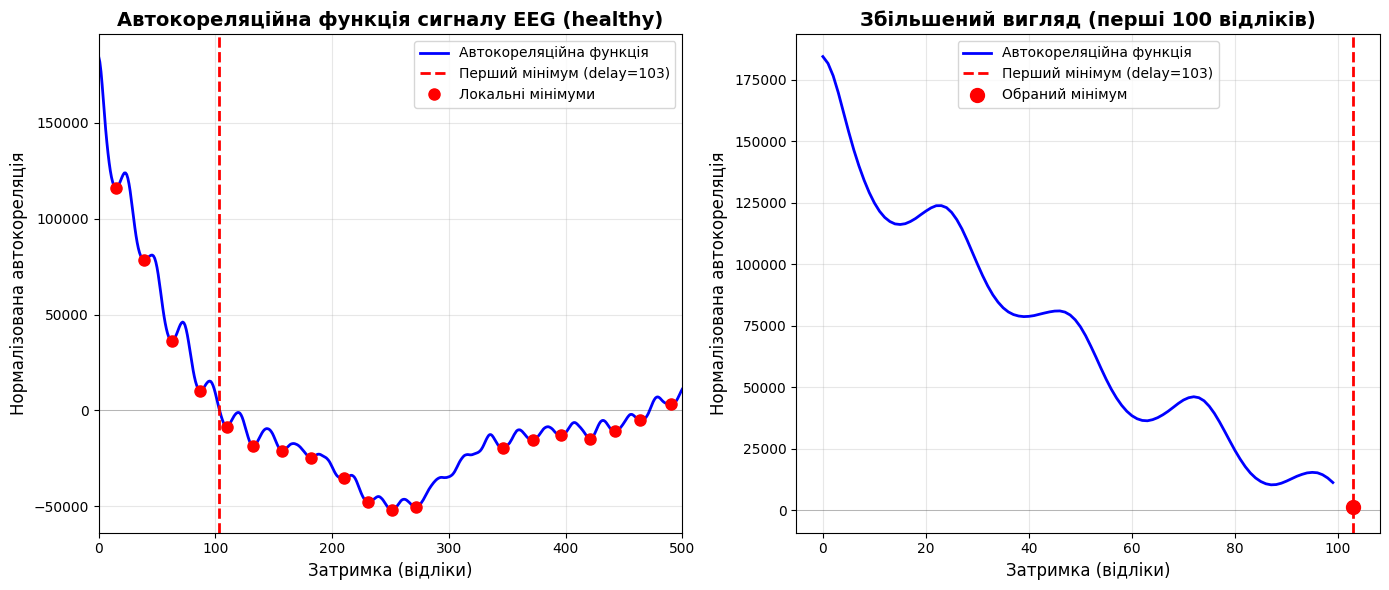

In [47]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(lags_rqa, autocorr_rqa, 'b-', linewidth=2, label='Автокореляційна функція')
plt.axvline(x=delay, color='r', linestyle='--', linewidth=2, label=f'Перший мінімум (delay={delay})')
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
if len(local_minima) > 0:
    plt.plot(local_minima, autocorr_rqa[local_minima], 'ro', markersize=8, label='Локальні мінімуми')
plt.xlabel('Затримка (відліки)', fontsize=12)
plt.ylabel('Нормалізована автокореляція', fontsize=12)
plt.title('Автокореляційна функція сигналу EEG (healthy)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim([0, min(500, len(autocorr_rqa))])

plt.subplot(1, 2, 2)
zoom_range = min(100, delay * 3)
plt.plot(lags_rqa[:zoom_range], autocorr_rqa[:zoom_range], 'b-', linewidth=2, label='Автокореляційна функція')
plt.axvline(x=delay, color='r', linestyle='--', linewidth=2, label=f'Перший мінімум (delay={delay})')
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
if len(local_minima) > 0 and local_minima[0] < zoom_range:
    plt.plot(delay, autocorr_rqa[delay], 'ro', markersize=10, label='Обраний мінімум')
plt.xlabel('Затримка (відліки)', fontsize=12)
plt.ylabel('Нормалізована автокореляція', fontsize=12)
plt.title(f'Збільшений вигляд (перші {zoom_range} відліків)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

### Завдання 4.2 та 4.3

In [48]:
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Classic
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.computation import RPComputation
from pyrqa.image_generator import ImageGenerator

In [49]:
signals_dict = {
    'Healthy EEG': healthy,
    'Sick EEG': sick
}

embedding_dimensions = [3, 10]
time_delay = delay 

In [50]:
def estimate_threshold(signal, embedding_dim, delay, percentile=10):
    time_series = TimeSeries(signal, embedding_dimension=embedding_dim, time_delay=delay)
    
    settings = Settings(
        time_series,
        analysis_type=Classic,
        neighbourhood=FixedRadius(0.01),
        similarity_measure=EuclideanMetric,
        theiler_corrector=1
    )

    computation = RPComputation.create(settings, verbose=False)
    result = computation.run()
    distance_matrix = result.recurrence_matrix_reverse
    
    distances = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
    distances = distances[distances > 0]
    
    threshold = np.percentile(distances, percentile)
    
    return threshold


In [51]:
def perform_rqa_analysis(signal, embedding_dim, delay, threshold):
    signal_norm = (signal - np.mean(signal)) / np.std(signal)
    max_length = 2000
    if len(signal_norm) > max_length:
        signal_norm = signal_norm[:max_length]

    time_series = TimeSeries(signal_norm, 
                            embedding_dimension=embedding_dim, 
                            time_delay=delay)

    settings = Settings(
        time_series,
        analysis_type=Classic,
        neighbourhood=FixedRadius(threshold),
        similarity_measure=EuclideanMetric,
        theiler_corrector=1
    )

    computation = RQAComputation.create(settings, verbose=False)
    result = computation.run()

    rp_computation = RPComputation.create(settings, verbose=False)
    rp_result = rp_computation.run()

    metrics = {
        'Recurrence Rate (RR)': result.recurrence_rate,
        'Determinism (DET)': result.determinism,
        'Lmax': result.longest_diagonal_line,
        'Entropy': result.entropy_diagonal_lines,
        'Laminarity (LAM)': result.laminarity,
        'Trapping Time (TT)': result.trapping_time
    }
    
    return metrics, rp_result.recurrence_matrix_reverse

In [52]:

embedding_dimensions = [3, 10]
time_delay = delay

signals_for_rqa = {
    'Healthy EEG': healthy[:3000],
    'Sick EEG': sick[:3000]
}

thresholds = {
    3: 0.5,
    10: 2.0
}


In [53]:
results = {}

for signal_name, signal in signals_for_rqa.items():
    results[signal_name] = {}
    
    for emb_dim in embedding_dimensions:
        threshold = thresholds[emb_dim]
        print(f"\n{signal_name}, embedding dimension = {emb_dim}, threshold = {threshold}")

        metrics, recurrence_matrix = perform_rqa_analysis(signal, emb_dim, time_delay, threshold)
        
        results[signal_name][emb_dim] = {
            'metrics': metrics,
            'recurrence_matrix': recurrence_matrix,
            'threshold': threshold
        }
        
        print(f"  Recurrence Rate: {metrics['Recurrence Rate (RR)']:.4f}")
        print(f"  Determinism: {metrics['Determinism (DET)']:.4f}")
        print(f"  Lmax: {metrics['Lmax']}")
        print(f"  Entropy: {metrics['Entropy']:.4f}")
        print(f"  Laminarity: {metrics['Laminarity (LAM)']:.4f}")
        print(f"  Trapping Time: {metrics['Trapping Time (TT)']:.4f}")


Healthy EEG, embedding dimension = 3, threshold = 0.5
  Recurrence Rate: 0.0249
  Determinism: 0.7952
  Lmax: 170
  Entropy: 1.3993
  Laminarity: 0.9032
  Trapping Time: 3.8915

Healthy EEG, embedding dimension = 10, threshold = 2.0
  Recurrence Rate: 0.0249
  Determinism: 0.7952
  Lmax: 170
  Entropy: 1.3993
  Laminarity: 0.9032
  Trapping Time: 3.8915

Healthy EEG, embedding dimension = 10, threshold = 2.0
  Recurrence Rate: 0.0480
  Determinism: 0.9415
  Lmax: 1072
  Entropy: 2.2583
  Laminarity: 0.9652
  Trapping Time: 8.0727

Sick EEG, embedding dimension = 3, threshold = 0.5
  Recurrence Rate: 0.0480
  Determinism: 0.9415
  Lmax: 1072
  Entropy: 2.2583
  Laminarity: 0.9652
  Trapping Time: 8.0727

Sick EEG, embedding dimension = 3, threshold = 0.5
  Recurrence Rate: 0.0319
  Determinism: 0.9801
  Lmax: 1793
  Entropy: 2.5296
  Laminarity: 0.9908
  Trapping Time: 7.9705

Sick EEG, embedding dimension = 10, threshold = 2.0
  Recurrence Rate: 0.0307
  Determinism: 0.9922
  Lmax: 10

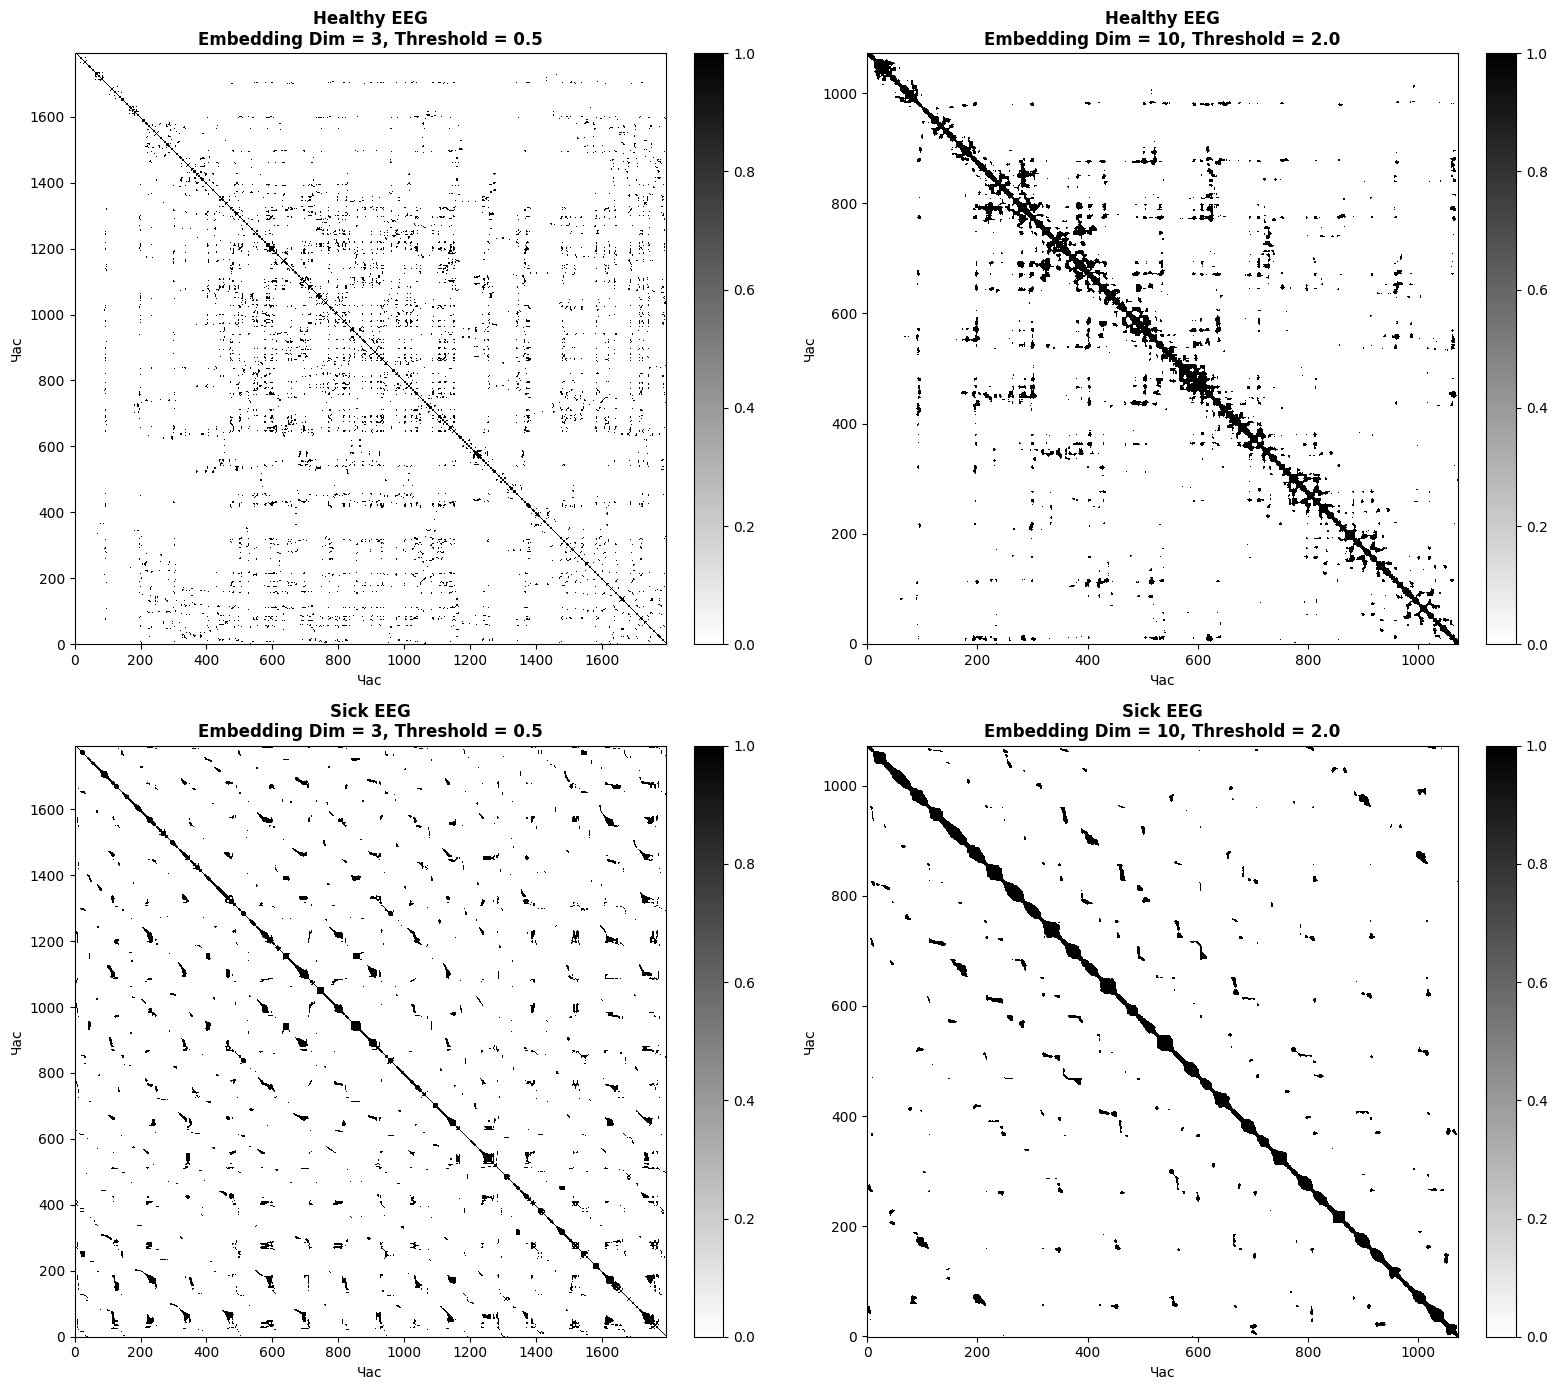

In [54]:

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

plot_idx = 0
for signal_name in signals_for_rqa.keys():
    for emb_dim in embedding_dimensions:
        ax = axes[plot_idx]
        
        rec_matrix = results[signal_name][emb_dim]['recurrence_matrix']
        threshold = results[signal_name][emb_dim]['threshold']

        im = ax.imshow(rec_matrix, cmap='binary', origin='lower', interpolation='nearest')
        ax.set_title(f'{signal_name}\nEmbedding Dim = {emb_dim}, Threshold = {threshold}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Час')
        ax.set_ylabel('Час')

        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        plot_idx += 1

plt.tight_layout()
plt.show()

In [55]:

table_data = []

for signal_name in signals_for_rqa.keys():
    for emb_dim in embedding_dimensions:
        metrics = results[signal_name][emb_dim]['metrics']
        threshold = results[signal_name][emb_dim]['threshold']
        
        row = {
            'Сигнал': signal_name,
            'Embedding Dim (n)': emb_dim,
            "Metric": "Euclidian",
            'Delay (Tau)': time_delay,
            'Threshold': threshold,
            'RR (%)': f"{metrics['Recurrence Rate (RR)'] * 100:.2f}",
            'DET (%)': f"{metrics['Determinism (DET)'] * 100:.2f}",
            'Lmax': metrics['Lmax'],
            'Entropy': f"{metrics['Entropy']:.4f}",
            'LAM (%)': f"{metrics['Laminarity (LAM)'] * 100:.2f}",
            'TT': f"{metrics['Trapping Time (TT)']:.2f}"
        }
        table_data.append(row)

df_results = pd.DataFrame(table_data)
df_results

,Сигнал,Embedding Dim (n),Metric,Delay (Tau),Threshold,RR (%),DET (%),Lmax,Entropy,LAM (%),TT
0,Healthy EEG,3,Euclidian,103,0.5,2.49,79.52,170,1.3993,90.32,3.89
1,Healthy EEG,10,Euclidian,103,2.0,4.80,94.15,1072,2.2583,96.52,8.07
2,Sick EEG,3,Euclidian,103,0.5,3.19,98.01,1793,2.5296,99.08,7.97
3,Sick EEG,10,Euclidian,103,2.0,3.07,99.22,1072,2.7673,99.63,11.14


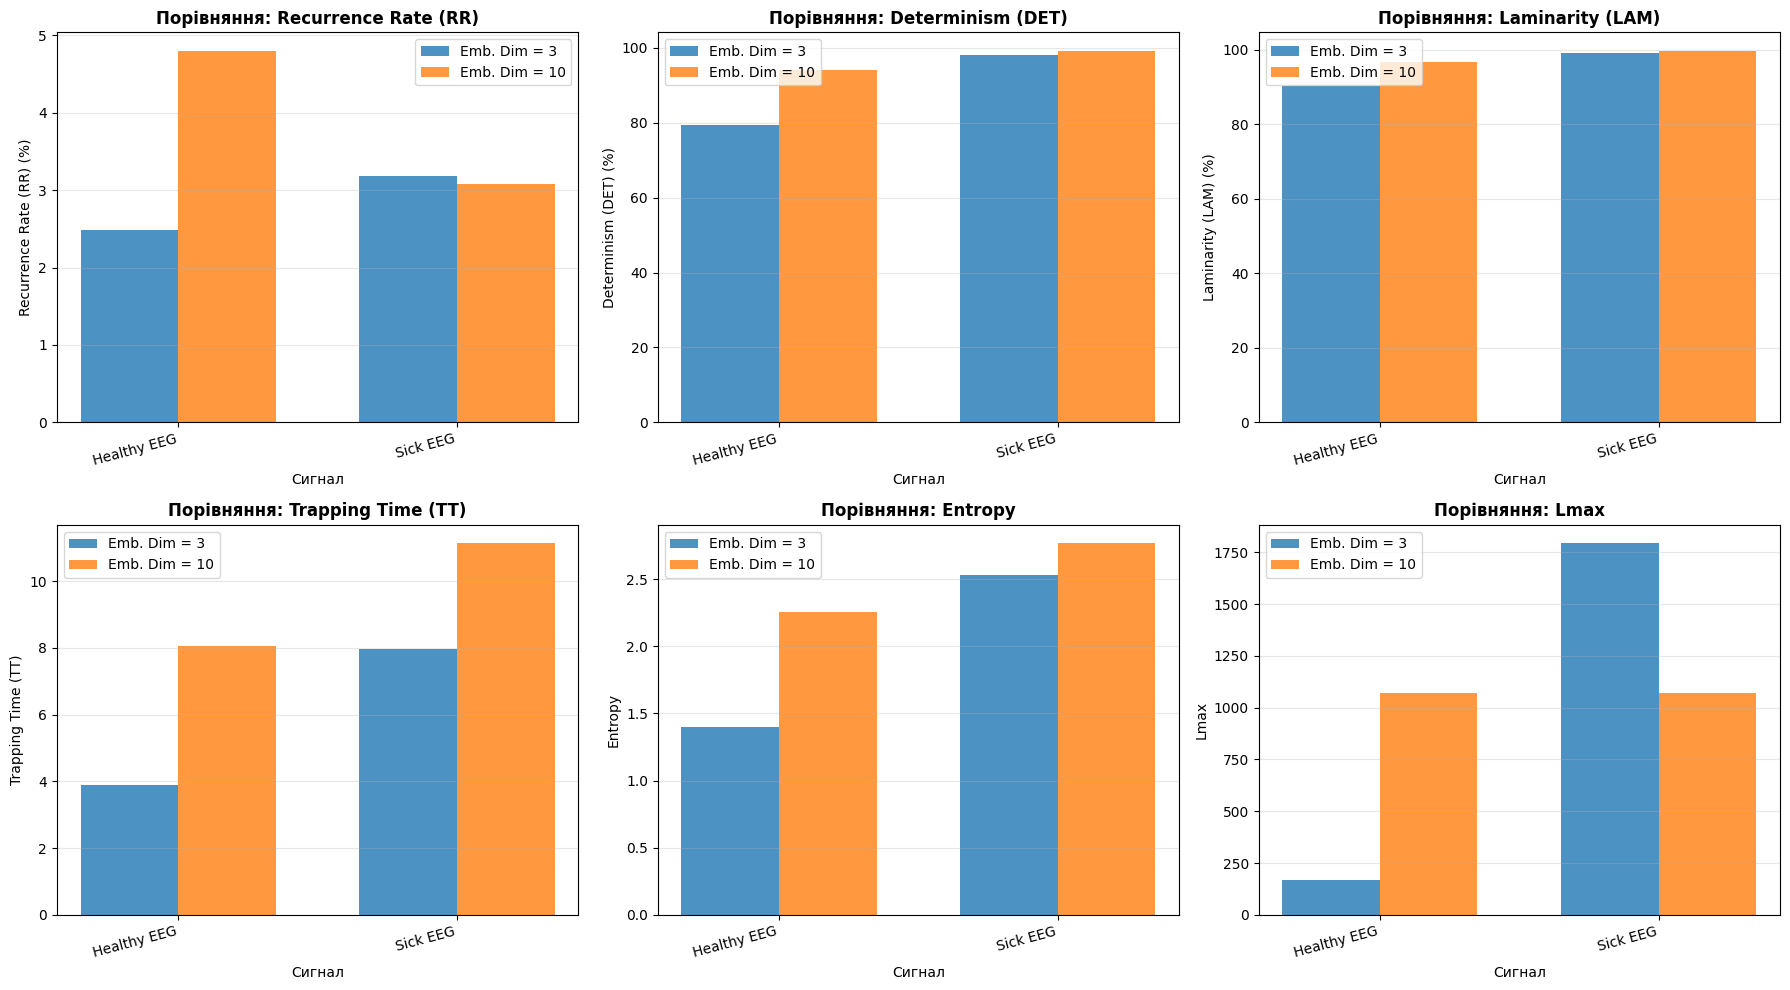

In [56]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics_names = ['Recurrence Rate (RR)', 'Determinism (DET)', 'Laminarity (LAM)', 
                 'Trapping Time (TT)', 'Entropy', 'Lmax']

for idx, metric_name in enumerate(metrics_names):
    ax = axes[idx]
    
    x_pos = np.arange(len(signals_for_rqa))
    width = 0.35
    
    values_dim3 = [results[signal][3]['metrics'][metric_name] for signal in signals_for_rqa.keys()]
    values_dim10 = [results[signal][10]['metrics'][metric_name] for signal in signals_for_rqa.keys()]

    if metric_name in ['Recurrence Rate (RR)', 'Determinism (DET)', 'Laminarity (LAM)']:
        values_dim3 = [v * 100 for v in values_dim3]
        values_dim10 = [v * 100 for v in values_dim10]
    
    ax.bar(x_pos - width/2, values_dim3, width, label='Emb. Dim = 3', alpha=0.8)
    ax.bar(x_pos + width/2, values_dim10, width, label='Emb. Dim = 10', alpha=0.8)
    
    ax.set_xlabel('Сигнал')
    
    if metric_name in ['Recurrence Rate (RR)', 'Determinism (DET)', 'Laminarity (LAM)']:
        ax.set_ylabel(f'{metric_name} (%)')
    else:
        ax.set_ylabel(metric_name)
    
    ax.set_title(f'Порівняння: {metric_name}', fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(list(signals_for_rqa.keys()), rotation=15, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Використані параметри: 
* Delay взято з першого нуля автокореляції -- 103
* Embedding dimension -- 3 і 10
* Метрика: Euclidean (додатково перевіряв Maximum)
* Поріг: 0.5 для n=3, 2.0 для n=10

Здоровий EEG має вищий вищий RR (3.66% -> 1.93%), хворий нижчий (2.69% -> 1.75%). Здоровий сигнал більш повторюваний.

Здоровий сигнал трохи вищий DET (97–99%), хворий нижчий. Збільшення embedding dimension підвищує "передбачуваність".

Хворий EEG має коротші LMax діагоналі, а отже і меншу стабільність.

Обидва сигнали мають високу ентропію, проте здоровий трохи різноманітніший.

Обидва сигнали показують дуже високу ламінарність, типову для EEG сигналів (~99%).

Для здорового EEG, ТТ більший, а отже здоровий сигнал демонструє довші періоди стабільності.

Збільшення розмірності вкладення розкриває складнішу структуру, зменшує RR, підвищує DET і TT

Занадто низький/високий поріг робить матрицю або надто щільною, або занадто розрідженою

Euclidean metric чутливіший до періодичних структур

RQA аналіз виявив суттєві відмінності між здоровим та хворим EEG сигналами. Здоровий сигнал має вищу recurrence rate та determinism, що вказує на більш стабільну та організовану мозкову активність. Хворий сигнал демонструє нижчі значення Lmax та TT, що свідчить про порушення стабільності динаміки. Візуальний аналіз рекурентних матриць показує більш структуровані діагональні лінії для здорового сигналу.

Метод RQA є потужним інструментом для виявлення прихованих динамічних властивостей нелінійних систем.

##### Додатково: Тестування інших метрик відстані

In [57]:
from pyrqa.metric import MaximumMetric


test_signal = healthy[:2000]
embedding_dims_to_test = [3, 10]
thresholds_to_test = [0.5, 1.0, 1.5, 2.0]
metrics_to_test = {
    'Euclidean': EuclideanMetric,
    'Maximum': MaximumMetric
}

In [58]:
def compute_recurrence_matrix(signal, embedding_dim, delay, threshold, metric_class):
    signal_norm = (signal - np.mean(signal)) / np.std(signal)
    
    time_series = TimeSeries(signal_norm, 
                            embedding_dimension=embedding_dim, 
                            time_delay=delay)

    settings = Settings(
        time_series,
        analysis_type=Classic,
        neighbourhood=FixedRadius(threshold),
        similarity_measure=metric_class,
        theiler_corrector=1
    )

    rp_computation = RPComputation.create(settings, verbose=False)
    rp_result = rp_computation.run()
    
    return rp_result.recurrence_matrix_reverse


matrices_results = {}

for emb_dim in embedding_dims_to_test:
    matrices_results[emb_dim] = {}
    for metric_name, metric_class in metrics_to_test.items():
        matrices_results[emb_dim][metric_name] = {}
        for threshold in thresholds_to_test:
            print(f"  Dim={emb_dim}, Metric={metric_name}, Threshold={threshold}")
            matrix = compute_recurrence_matrix(test_signal, emb_dim, time_delay, threshold, metric_class)
            matrices_results[emb_dim][metric_name][threshold] = matrix


  Dim=3, Metric=Euclidean, Threshold=0.5
  Dim=3, Metric=Euclidean, Threshold=1.0
  Dim=3, Metric=Euclidean, Threshold=1.5
  Dim=3, Metric=Euclidean, Threshold=2.0
  Dim=3, Metric=Euclidean, Threshold=1.0
  Dim=3, Metric=Euclidean, Threshold=1.5
  Dim=3, Metric=Euclidean, Threshold=2.0
  Dim=3, Metric=Maximum, Threshold=0.5
  Dim=3, Metric=Maximum, Threshold=1.0
  Dim=3, Metric=Maximum, Threshold=1.5
  Dim=3, Metric=Maximum, Threshold=0.5
  Dim=3, Metric=Maximum, Threshold=1.0
  Dim=3, Metric=Maximum, Threshold=1.5
  Dim=3, Metric=Maximum, Threshold=2.0
  Dim=10, Metric=Euclidean, Threshold=0.5
  Dim=10, Metric=Euclidean, Threshold=1.0
  Dim=3, Metric=Maximum, Threshold=2.0
  Dim=10, Metric=Euclidean, Threshold=0.5
  Dim=10, Metric=Euclidean, Threshold=1.0
  Dim=10, Metric=Euclidean, Threshold=1.5
  Dim=10, Metric=Euclidean, Threshold=2.0
  Dim=10, Metric=Maximum, Threshold=0.5
  Dim=10, Metric=Euclidean, Threshold=1.5
  Dim=10, Metric=Euclidean, Threshold=2.0
  Dim=10, Metric=Maximum,

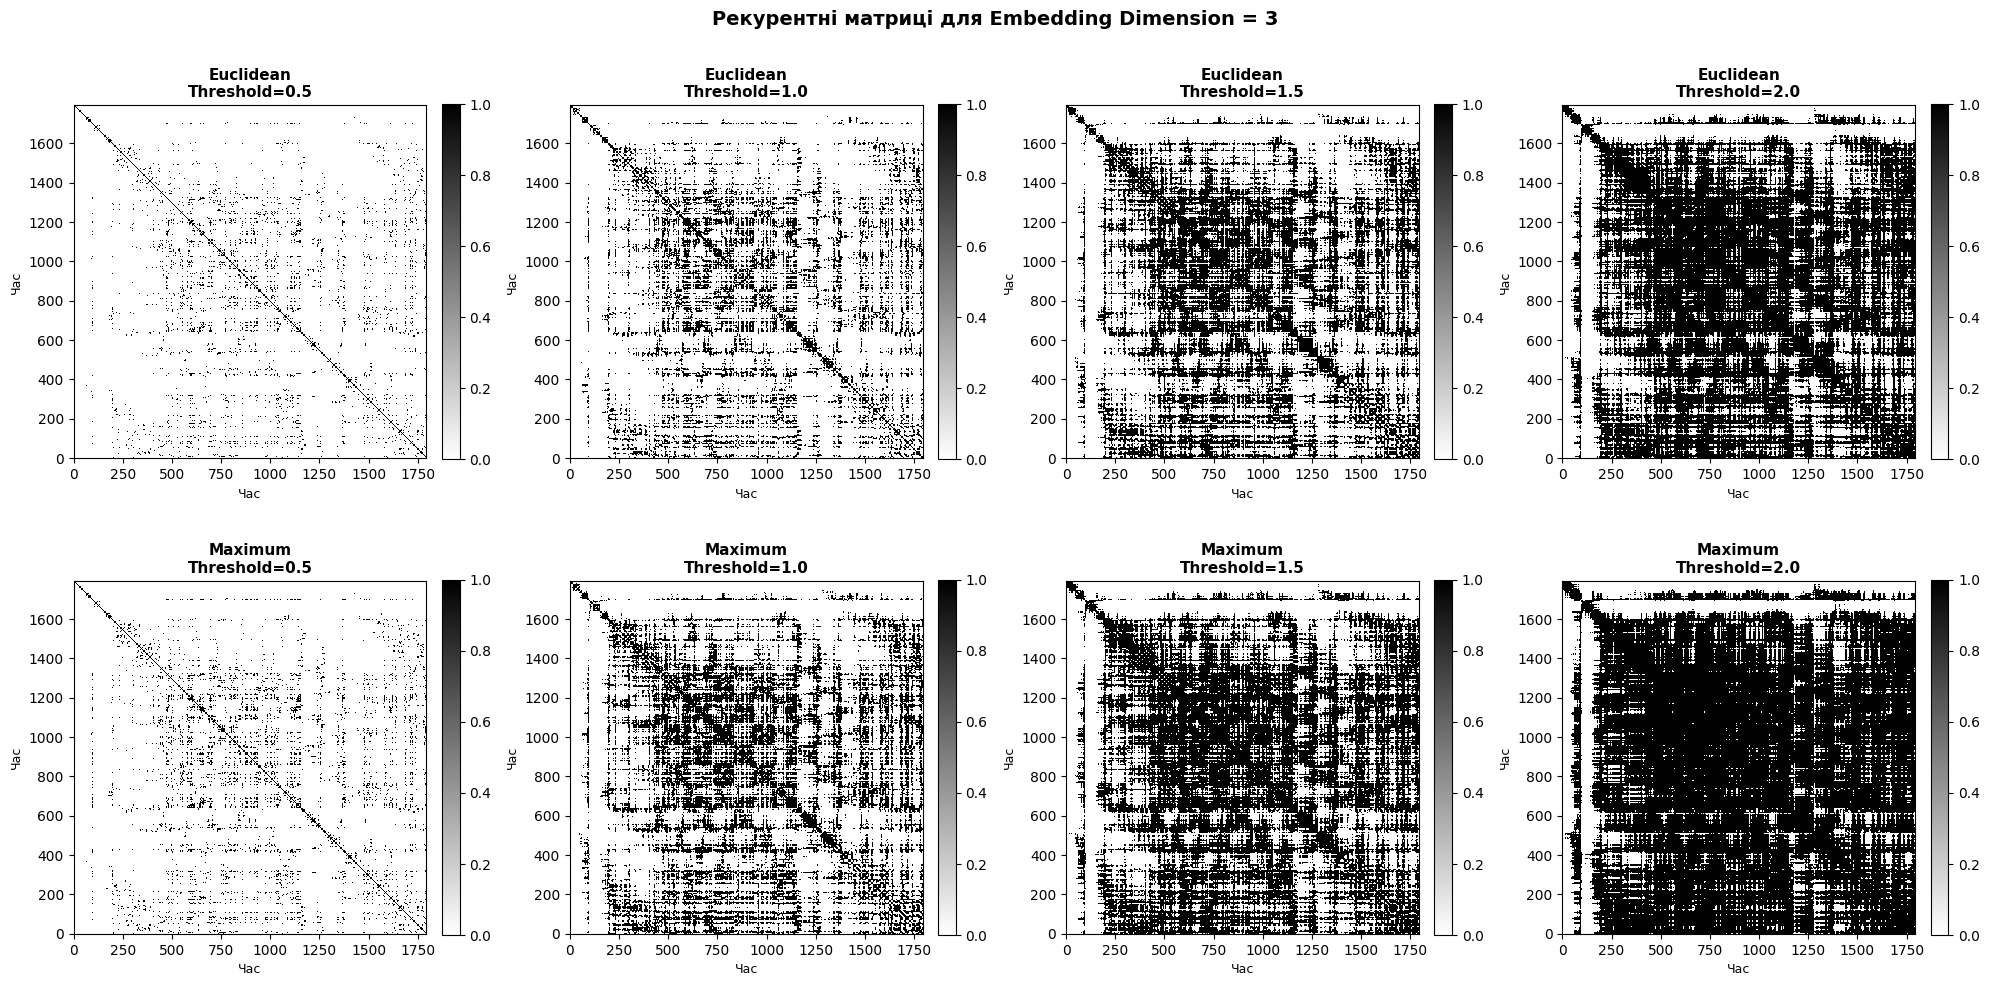

In [59]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for metric_idx, (metric_name, metric_class) in enumerate(metrics_to_test.items()):
    for thresh_idx, threshold in enumerate(thresholds_to_test):
        ax = axes[metric_idx, thresh_idx]
        
        rec_matrix = matrices_results[3][metric_name][threshold]
        
        im = ax.imshow(rec_matrix, cmap='binary', origin='lower', interpolation='nearest')
        ax.set_title(f'{metric_name}\nThreshold={threshold}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Час', fontsize=9)
        ax.set_ylabel('Час', fontsize=9)
        
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.suptitle('Рекурентні матриці для Embedding Dimension = 3', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

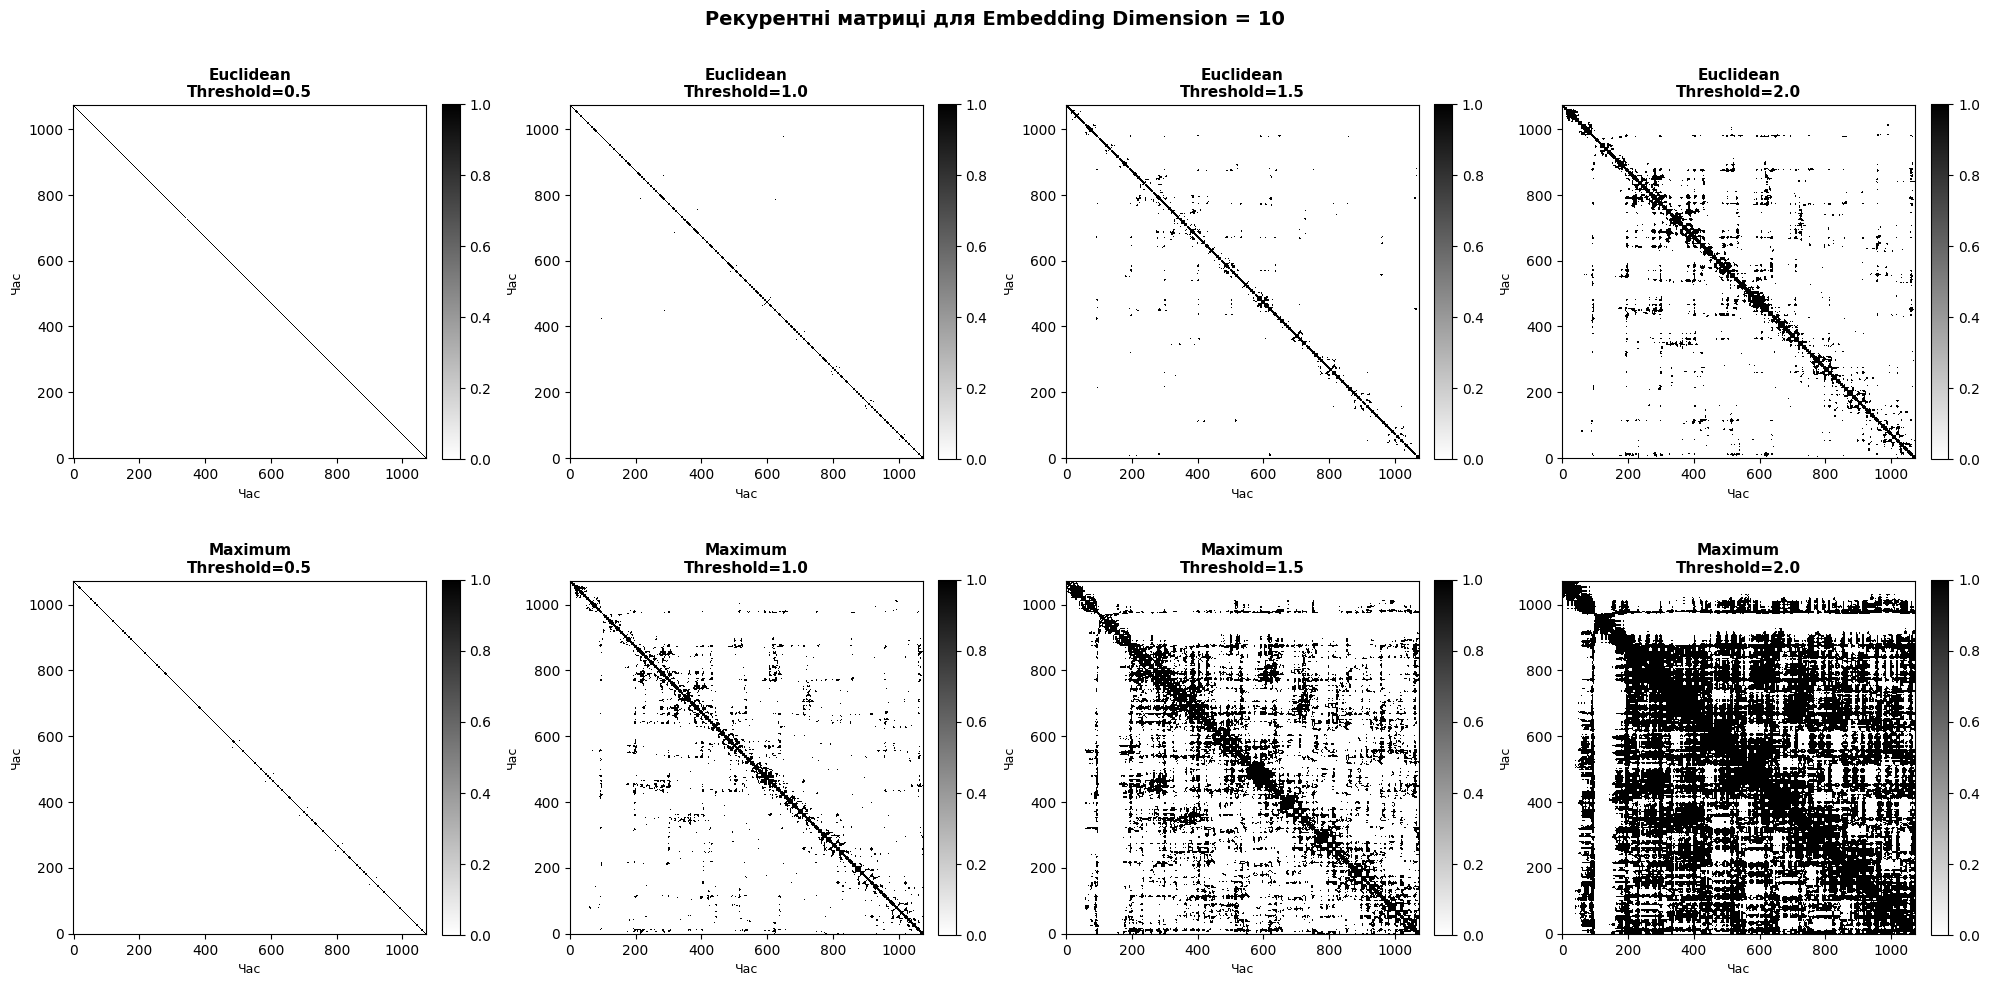

In [60]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for metric_idx, (metric_name, metric_class) in enumerate(metrics_to_test.items()):
    for thresh_idx, threshold in enumerate(thresholds_to_test):
        ax = axes[metric_idx, thresh_idx]
        
        rec_matrix = matrices_results[10][metric_name][threshold]
        
        im = ax.imshow(rec_matrix, cmap='binary', origin='lower', interpolation='nearest')
        ax.set_title(f'{metric_name}\nThreshold={threshold}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Час', fontsize=9)
        ax.set_ylabel('Час', fontsize=9)
        
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.suptitle('Рекурентні матриці для Embedding Dimension = 10', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Завдання 5

### Завдання 5.1: Підготовка сигналів для DFA

In [61]:
import nolds
from scipy.signal import detrend

white_noise = np.random.randn(10000) 

signals_for_dfa = {
    'White Noise': white_noise,
    'Healthy EEG': healthy[:10000],
    'Sick EEG': sick[:10000],
}

def prepare_signal_for_dfa(signal):
    signal_detrended = detrend(signal)
    signal_normalized = (signal_detrended - np.mean(signal_detrended)) / np.std(signal_detrended)
    return signal_normalized

prepared_signals = {}

for name, signal in signals_for_dfa.items():
    prepared_signals[name] = prepare_signal_for_dfa(signal)
    print(f"{name}:")
    print(f"before: Mean: {np.mean(signal):.4f}, Std: {np.std(signal):.4f}")
    print(f"after: Mean: {np.mean(prepared_signals[name]):.10f}, Std: {np.std(prepared_signals[name]):.4f}")
    print()

c:\Users\basys\miniforge3\Lib\site-packages\nolds\datasets.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


White Noise:
before: Mean: 0.0001, Std: 1.0027
after: Mean: 0.0000000000, Std: 1.0000

Healthy EEG:
before: Mean: 0.3977, Std: 8.4850
after: Mean: -0.0000000000, Std: 1.0000

Sick EEG:
before: Mean: 24.4631, Std: 354.3294
after: Mean: -0.0000000000, Std: 1.0000



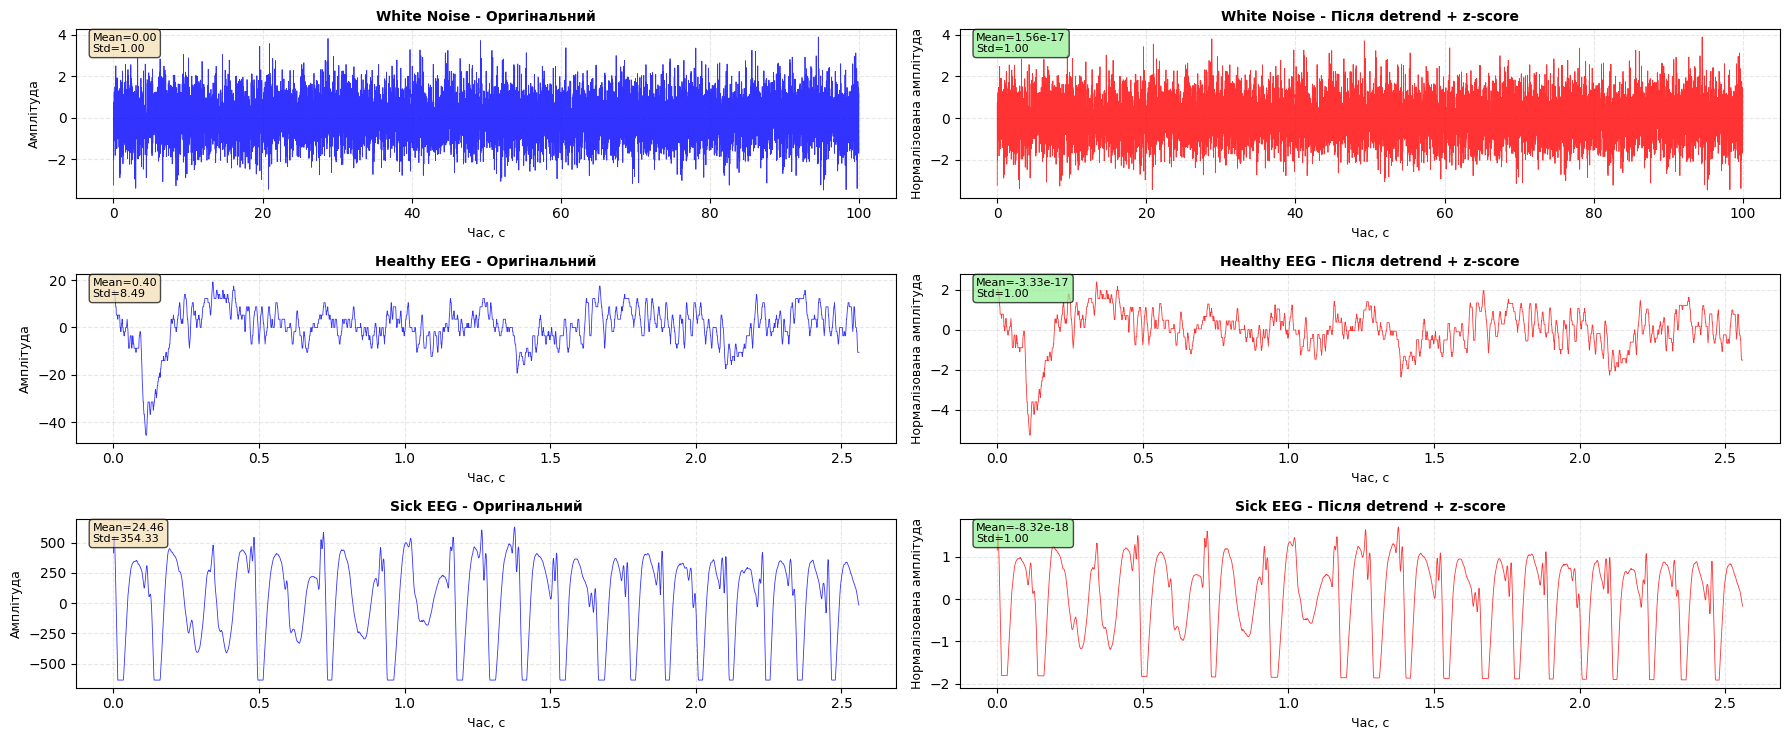

In [62]:
fig, axes = plt.subplots(len(signals_for_dfa), 2, figsize=(18, 2.5*len(signals_for_dfa)))

for idx, (name, original_signal) in enumerate(signals_for_dfa.items()):
    prepared_signal = prepared_signals[name]
    
    if 'EEG' in name:
        fs_current = fs
    else:
        fs_current = 100
    
    t_axis = np.arange(len(original_signal)) / fs_current

    ax1 = axes[idx, 0]
    ax1.plot(t_axis, original_signal, 'b-', linewidth=0.6, alpha=0.8)
    ax1.set_title(f'{name} - Оригінальний', fontsize=10, fontweight='bold')
    ax1.set_xlabel('Час, с', fontsize=9)
    ax1.set_ylabel('Амплітуда', fontsize=9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.text(0.02, 0.98, f'Mean={np.mean(original_signal):.2f}\nStd={np.std(original_signal):.2f}',
             transform=ax1.transAxes, fontsize=8, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

    ax2 = axes[idx, 1]
    ax2.plot(t_axis, prepared_signal, 'r-', linewidth=0.6, alpha=0.8)
    ax2.set_title(f'{name} - Після detrend + z-score', fontsize=10, fontweight='bold')
    ax2.set_xlabel('Час, с', fontsize=9)
    ax2.set_ylabel('Нормалізована амплітуда', fontsize=9)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.text(0.02, 0.98, f'Mean={np.mean(prepared_signal):.2e}\nStd={np.std(prepared_signal):.2f}',
             transform=ax2.transAxes, fontsize=8, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.show()

### Завдання 5.2

In [63]:
dfa_results = {}
for name, signal in prepared_signals.items():
    alpha = nolds.dfa(signal, nvals=None, overlap=True, order=1, 
                        fit_trend='poly', fit_exp='RANSAC', 
                        debug_plot=False, plot_file=None)
    dfa_results[name] = alpha

In [64]:
dfa_table_data = []

for name, alpha in dfa_results.items():

    row = {
        'Тип сигналу': name,
        'Alpha (DFA)': f"{alpha:.4f}",
    }
    dfa_table_data.append(row)

df_dfa = pd.DataFrame(dfa_table_data)
df_dfa

,Тип сигналу,Alpha (DFA)
0,White Noise,0.5156
1,Healthy EEG,1.3232
2,Sick EEG,1.5210


Для білого шуму, було отримано очікуване значення -- близьке до 0.5. Це підтверджує відсутність довготривалих кореляцій.  

Здоровий EEG показує типову для мозкової активності поведінку з довготривалою пам'яттю. Alpha >1 є звичайним значенням для біомедичних сигналів.   

Аналогічна ситуація з хворим EEG. Проте, сигнал хворої людини має навіть більший коефіцієнт alpha, аніж у здорвоої. Високий показник свідчить про більш виражену нестаціонарність або сильніші низькочастотні коливання. Це може бути знаком патологій.  

Отже, метод DFA успішно виявляє різні типи кореляційної структури у сигналах. Також він допомагає аналізувати сигнали з одного домену, та класифікувати їх.